In [ ]:
# huggingface libary 설치
!pip install transformers

     |████████████████████████████████| 3.8 MB 7.9 MB/s 
     |████████████████████████████████| 6.5 MB 72.2 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
     |████████████████████████████████| 596 kB 71.7 MB/s 
     |████████████████████████████████| 895 kB 61.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


# I. Data

## A. 학습 데이터 추가 
- '스포탈코리아' 매거진에 해당하는 제목, 내용 1,000개 추가 크롤링 및 학습에 활용(validation을 위한 보완)
- 총 10,000 개의 dataset을 training:validate:test = 7:1:2 로 나누어 활용
- 2022.03.20 기준 가장 최근의 기사 1000개를 검색한 결과

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:


import requests
from bs4 import BeautifulSoup

content_list = []
title_list = []


# page 번호 id로 변환
def page_to_id(n):
  return 10*n-9

# Beautiful soup를 이용하여 페이지 당 기사 및 본문 내용을 크롤링하는 코드.
def search_with_pages(n):
    for i,m in enumerate(range(n)):
        m=page_to_id(m)
        if i%10==9:
          print(f"{i+1}번 페이지 기록중입니다.---------------------------------------")
        resp = requests.get(f"https://search.naver.com/search.naver?where=news&sm=tab_pge&query=%EC%8A%A4%ED%8F%AC%ED%83%88%EC%BD%94%EB%A6%AC%EC%95%84&sort=0&photo=0&field=0&pd=0&ds=&de=&cluster_rank=10&mynews=0&office_type=0&office_section_code=0&news_office_checked=&nso=so:r,p:all,a:all&is_sug_officeid=1&start={m}") # keyword를 input으로 받음
    

        html = resp.text
        # print(html)

        soup = BeautifulSoup(html,"html.parser")
        # 선택자에 해당하는 모든 것들을 link로 담아온다!
        links = soup.select('.news_tit')
        # print(links) #list 형태로 담겨져 있음
        for link in links: #각 link는 <a>내용 </a> 의 html
            title = link.text # 태그 안에 텍스트요소 가져온다! -> 제목
            url = link.attrs['href'] # href=""의 속성값을 가져온다. -> 링크
            idx=url.find('§')
            url=url[:idx] # ion code 제거

            # url로 content 접속
            resp = requests.get(url)
            # html= resp.text
            soup = BeautifulSoup(resp.content.decode('euc-kr','replace'),'html.parser')
            # print(soup)
            content = soup.select_one('.review_text02')
            content = content.text

            # print(title, content) # 제목, 링크 크롤링 완료!
            content_list.append(content)
            title_list.append(title)
    columns = ['content', 'title']
    df = pd.DataFrame([x for x in zip(content_list, title_list)], columns = columns)
    print("기록을 완료했습니다.")
    return df

# 함수 실행
df_news = search_with_pages(100) # 1페이지 당 10개의 기사

In [ ]:
# 크롤링한 1000개 데이터 저장
df_news.to_csv('/content/drive/MyDrive/[Wanted]기업과제4/sports_news_data_additional.csv')

## B. 데이터 확인 및 EDA
- TITLE, CONTENT, PUBLISH_DT 로 이루어져 있음.
- 결측치 및 중복치 : 각 2개, 42개
- (제거 후) 데이터 수 : 10033
- 본문 단어 개수 : 약 180개(평균)
- 요약문 단어 개수 : 약 9~10개(평균)
- 요약된 단어 개수 비율 : **0.05** 
  - 이후 generate시 요약 비율 선정(max_min length 설정) 시 참고
  - 토크나이징 된 토큰 개수 분포와 단어 개수 분포에는 차이가 있으므로 비율로 선정 후 학습
- CONTENT 정보를 요약 및 추출하는 것이 필요해 보임.

In [ ]:
# 파일 불러오기 및 병합

path1 = '/content/drive/MyDrive/[Wanted]기업과제4/sports_news_data.csv'
path2 = '/content/drive/MyDrive/[Wanted]기업과제4/sports_news_data_additional.csv'
df = pd.read_csv(path1, on_bad_lines='skip')# delimiter='\t')
df_news = pd.read_csv(path2, on_bad_lines='skip')# delimiter='\t')
df_news.drop(['Unnamed: 0'], axis = 1, inplace = True)# unnamed column 제거

df_news['PUBLISH_DT'] = pd.Series(['2022-03-20' for _ in range(len(df_news))])
# df = df[['CONTENT', 'TITLE']] # PUBLISH_DT 제거
df.columns = ['title', 'content','PUBLISH_DT']



df = pd.concat([df_news, df]) # 1000개 data가 앞에 오도록 함
df.reset_index(drop=True, inplace=True) # 다시 indexing

df.tail()

,content,title,PUBLISH_DT
10072,[스포탈코리아] 한재현 기자= FC바르셀로나(이하 바르사) 팬들에게 우스망 뎀벨레는...,"이제 홈팬 야유 받는 먹튀 선수, 차비 감독 조차 “그만 해라”",2022-02-07
10073,[스포탈코리아] 한재현 기자=성남FC가 만17세 2004년생 수비수 김지수와 준프로...,"[오피셜] 성남, 만 17세 유스 김지수와 준프로 계약",2022-02-07
10074,[스포탈코리아] 곽힘찬 기자= '레전드' 마르크 오베르마스가 아약스에서 쫓겨났다. ...,"오베르마스, 아약스서 쫓겨난다...'여성 동료들에게 부적절한 메시지'",2022-02-07
10075,[스포탈코리아] 고윤준 기자= FC 바르셀로나 차비 에르난데스 감독이 데뷔전을 치른...,"바르사 차비 감독, 트라오레 데뷔전 활약에 깜짝...""몸이 야수 같아""",2022-02-07
10076,[스포탈코리아] 반진혁 기자= 이름값만 화려한 맨유 워스트 11이 공개됐다.\n\n...,‘데파이-팔카오-산체스-디 마리아’ 퍼거슨 경 은퇴 후 맨유 워스트 11,2022-02-07


In [ ]:
len(df)

10077

In [ ]:
df.content.iloc[0]

'[스포탈코리아] 김희웅 기자= 어느 때보다 잘나가는 아스널. 그러나 구단 전설은 라이벌 토트넘 홋스퍼가 마지막에 웃으리라 전망했다.\n\r\n스페인 매체 ‘마르카’는 20일(한국 시간) “아스널 레전드 마틴 키언은 토트넘이 유럽축구연맹(UEFA) 챔피언스리그(UCL) 티켓을 차지할 유력한 후보로 보고 있다”며 발언을 전했다.\n\r\n현재 아스널(승점 54)은 4위를 달리고 있다. 토트넘(승점 48)에 6점이나 앞서 있다. 이제 10경기만 남겨두고 있어 아스널의 UCL 진출이 유력한 상황이다. 때에 따라서는 3위 첼시(승점 59)의 자리를 뺏을 수도 있다. \n\n\n\r\n그러나 키언은 “토트넘이 실제 4위로 시즌을 마칠 가능성이 크다. 물론 아스널은 좋은 위치에 있다. 아스널이 지금처럼 계속할 수 있다면 (UCL 진출이) 가능하다. 하지만 여전히 갈 길이 멀다”고 분석했다.\n\r\n아스널은 A매치 휴식기를 가진 뒤 오는 4월 5일 크리스탈 팰리스와 격돌한다. 키언은 “패트릭 비에이라 감독이 아스널을 상대로 뭔가 하고 싶어할 것이다. 힘든 경기들이 다가오고 있다. 팰리스는 원정 경기에서 5승을 거뒀다”며 경계했다.\n\r\n무엇보다 아스널은 4월 일정을 잘 넘겨야 한다. 아스널은 내달 21일 첼시전을 시작으로 맨체스터 유나이티드, 웨스트햄 유나이티드와 차례로 격돌한다. 직접 순위 경쟁을 하는 팀들이기에 이때의 결과가 UCL 티켓의 향방을 결정할 거로 예상된다.\n\r\n사진=게티이미지코리아 '

In [ ]:
# 결측치 확인
df.isnull().sum()

content       2
title         0
PUBLISH_DT    0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
# 중복치 확인
df.duplicated(subset = 'content').sum()

42

In [ ]:
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)

In [ ]:
df_for_submission = df
len(df)

10033

### 1) 전처리 방법
- 요약에 있어 불필요한 부분 제거
  - `사진=*`
  - `[스포탈코리아]`
  - `000 기자=` 
- 이외에 특수문자 및 html 태그 제거


In [ ]:
# 전처리 함수

import re


'''
전처리에 참고한 사항:
AI허브의 훈련데이터와 비슷한 양상으로 전처리
()와 따옴표는 사용 가능 
줄바꿈문자는 없었음
 
'''

def preprocess(sen):

  # 사진 관련된 내용 삭제
  if sen.find('사진=') != -1:
    idx = sen.find('사진=')
    sen = sen[:idx] # 사진= 뒤로는 다 삭제

  # 앞부분 삭제 ex)[스포탈코리아]
  if sen.find(']') != -1:
    idx = sen.find(']')
    sen = sen[idx+2:] # ]뒤에 띄어쓰기 한칸 있는 것까지 포함해서 삭제
  
  # 기자이름 제거
  if sen.find('기자=') != -1: 
    idx = sen.find('기자=')
    sen = sen[idx+4:] # ]뒤에 띄어쓰기까지 삭제
  if sen.find('기자 =') != -1: 
    idx = sen.find('기자 =')
    sen = sen[idx+4:] # ]뒤에 띄어쓰기까지 삭제
  
  # \n 삭제
  sen = sen.replace('\n',"")
    
  # HTML 태그 삭제
  sen= re.sub(r"<.*?>", " ", sen) 

  return sen

In [ ]:
# 전문 확인
for i in df.content.sample(1):
  print(preprocess(i))

 바르셀로나가 그토록 공을 들여온 페란 토레스(21)를 영입하는 데 성공하면서 공격 보강 작업을 마쳤다. 토레스는 바르셀로나에서 다시 예전 폭발적인 모습을 되찾으면서 새로운 에이스로 올라설 수 있을지 주목된다.  바르셀로나는 28일(한국시간) 구단 공식 홈페이지를 통해 "토레스 영입을 완료했다. 계약 기간은 2027년 6월 30일까지며, 바이아웃은 10억 유로(약 1조 3,000억 원)다"고 발표했다. 현지 보도에 따르면 기본 이적료 5천 5백만 유로(약 740억 원)에 천만 유로(약 135억 원) 보너스 조항이 삽입된 것으로 전해졌다.  이번 겨울 이적시장을 앞두고 바르셀로나는 공격 보강에 몰두했다. 올여름 영입한 세르히오 아구에로(33)는 부정맥으로 인해 은퇴했고, 뤽 더용(31)은 기대 이하의 모습만 보여줬던 게 이유다. 그나마 제 몫을 해줬던 멤피스 데파이(27) 역시 최근 부상자 명단에 이름을 올렸다.  당초 지난 10월부터 라힘 스털링(26)을 강력히 원했지만 이적료에서 견해차가 컸다. 이에 사비 에르난데스(41·스페인) 감독이 적극적으로 추천한 토레스로 영입 타깃을 선회했다. 협상 과정은 역시나 순탄치 않았다. 이번에도 이적료에서 문제가 생겼다. 그러나 바르셀로나는 총 세 차례 제안 끝에 협상에 성공하면서 영입하게 됐다.  토레스는 발렌시아 유소년팀에서 성장해 차세대 스페인의 측면 공격을 책임질 선수로 기대를 모았다. 측면에서 빠른 스피드와 탁월한 드리블 돌파가 최대 장점이며, 킥력과 득점력도 고루 갖췄다. 최근에는 연계 능력도 한 단계 발전했다는 평가를 받았다.  발렌시아에서 주전으로 활약하며 통산 97경기 9골 12도움을 올렸고, 이런 활약상 속에 지난해 여름 맨체스터 시티에 입단했다. 맨시티에서 첫 시즌 선발과 교체를 오가며 공식전 36경기에서 13골 3도움을 기록했다. 특히 2선 어디에서나 뛸 수 있으며, 심지어 제로톱까지 소화하면서 다재다능함을 인정받았다.  그러나 올 시즌은 잭 그릴리쉬(26)가 새롭게 합류하고, 가브리엘 제주스(24),

In [ ]:
# 전처리 적용
df.content = df.content.apply(preprocess)
df.title = df.title.apply(preprocess)
df.head()

,content,title,PUBLISH_DT
0,어느 때보다 잘나가는 아스널. 그러나 구단 전설은 라이벌 토트넘 홋스퍼가 마지막에 ...,"진심인가? 아스널 전설 “토트넘이 TOP4, 아스널은 갈 길 멀어”",2022-03-20
1,수원FC 이승우가 6경기 만에 K리그 데뷔골을 신고했다. \r수원FC는 20일 오후...,"‘데뷔골+춤사위’ 이승우, 서서히 타오르고 있다",2022-03-20
2,하나금융그룹과 손잡고 첼시 인수에 뛰어든 영국 부동산 재벌 닉 캔디의 남다른 첼시 ...,“아빠 유골 첼시 구장에 뿌려” 하나금융과 손잡은 英 재벌의 '미친 일화',2022-03-20
3,해리 매과이어(맨체스터 유나이티드)의 국가대표팀 승선 소식에 말이 많다.\r가레스 ...,‘경기 안봐?’ 매과이어 국대 발탁에 의문 폭발… 英 감독 “빠질 이유 없어...,2022-03-20
4,마우리시오 포체티노 파리 생제르맹 감독이 토트넘 홋스퍼에 복귀할 수 있다는 보도가 ...,3년 만에 SON과 재회? “토트넘으로 로맨틱한 복귀 원할 것”,2022-03-20


In [ ]:
# 단어개수 세기 위한 함수
def splitword(x):
  return x.split(' ')

In [ ]:
df['content_len'] = df.content.apply(splitword).apply(len)
df['title_len'] = df.title.apply(splitword).apply(len)
df['sum_ratio'] = df['title_len']/df['content_len']
df.head()

,content,title,PUBLISH_DT,content_len,title_len,sum_ratio
0,어느 때보다 잘나가는 아스널. 그러나 구단 전설은 라이벌 토트넘 홋스퍼가 마지막에 ...,"진심인가? 아스널 전설 “토트넘이 TOP4, 아스널은 갈 길 멀어”",2022-03-20,148,9,0.060811
1,수원FC 이승우가 6경기 만에 K리그 데뷔골을 신고했다. \r수원FC는 20일 오후...,"‘데뷔골+춤사위’ 이승우, 서서히 타오르고 있다",2022-03-20,256,5,0.019531
2,하나금융그룹과 손잡고 첼시 인수에 뛰어든 영국 부동산 재벌 닉 캔디의 남다른 첼시 ...,“아빠 유골 첼시 구장에 뿌려” 하나금융과 손잡은 英 재벌의 '미친 일화',2022-03-20,175,11,0.062857
3,해리 매과이어(맨체스터 유나이티드)의 국가대표팀 승선 소식에 말이 많다.\r가레스 ...,‘경기 안봐?’ 매과이어 국대 발탁에 의문 폭발… 英 감독 “빠질 이유 없어...,2022-03-20,229,12,0.052402
4,마우리시오 포체티노 파리 생제르맹 감독이 토트넘 홋스퍼에 복귀할 수 있다는 보도가 ...,3년 만에 SON과 재회? “토트넘으로 로맨틱한 복귀 원할 것”,2022-03-20,208,9,0.043269


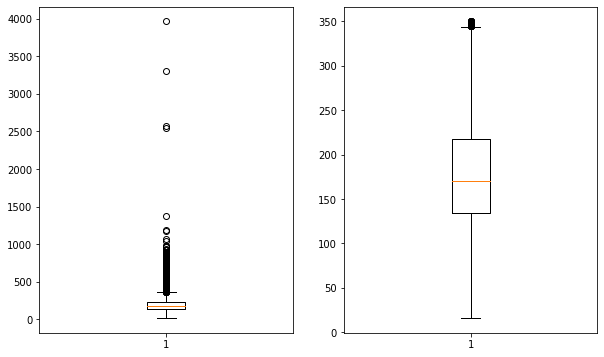

In [ ]:
# boxplot으로 content 단어 수 시각화

fig, axes = plt.subplots(1,2,figsize=(10,6))
axes[0].boxplot(df['content_len'])
# plt.show()
# delete outlier for generation
def clipping(x):
  if len(x.split(' '))>350: # token이 1000개가 넘어갈 경우, CUDA error가 일어남. 상위 25% 로 clipping
    x=x[:350]
  return x 
df.content = df.content.apply(clipping)
df['content_len_'] = df.content.apply(splitword).apply(len)
axes[1].boxplot(df['content_len_'])
fig.show()

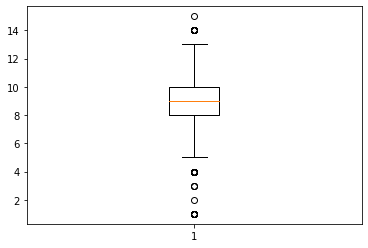

In [ ]:
# boxplot으로 title 단어수 시각화

ax= plt.boxplot(df['title_len'])

In [ ]:
# content 단어수 분포 확인
df.content_len_.describe()

count    10033.000000
mean       178.215589
std         61.668938
min         16.000000
25%        134.000000
50%        170.000000
75%        218.000000
max        350.000000
Name: content_len_, dtype: float64

In [ ]:
# title 단어수 분포 확인
df.title_len.describe()

count    10033.000000
mean         8.567228
std          1.625005
min          1.000000
25%          8.000000
50%          9.000000
75%         10.000000
max         15.000000
Name: title_len, dtype: float64

In [ ]:
# title/content 분포 확인
df.sum_ratio.describe()

count    10033.000000
mean         0.050663
std          0.022120
min          0.002041
25%          0.035461
50%          0.047619
75%          0.062069
max          0.312500
Name: sum_ratio, dtype: float64

# II. Model selection

## A. Model description : [kobart-news](https://huggingface.co/ainize/kobart-news)(pretrained)
### BART
- MLM을 활용한 bi-directional 한 encoding model 인 BERT와, 단방향 Autoregressive model인 GPT 를 결합한 encoder-decoder model
- 요약 task 수행에 적합함
- 그 중에서도 KoBART는 한국어 데이터를 통해 학습하였음

- kobart 모델을 [ai hub에 문서요약 데이터](https://aihub.or.kr/aidata/8054)에 finetuning 한 모델
- 원문 데이터 40만 건 (신문기사 30만 건, 기고문 6만 건, 잡지기사 1만 건, 법원 판결문 3만 건)을 활용하여 각각 추출요약 40만 건, 생성요약 40만 건, 총 80만 건의 요약문 도출
- Ainize Teachable-NLP 사용
  - [Teachable NLP](https://ainize.ai/teachable-nlp)란?

- BART 기반 pretrained model이므로, method 및 parameter는 [BART huggingface 공식문서](https://huggingface.co/docs/transformers/model_doc/bart) 참고.

### 1) 모델 선정 기준

a.	한국어 요약본 dataset으로 Pretrained 된 모델인가?

  - 뉴스기사 형태의 data로 학습했으므로 주어진 task에도 알맞은 pretrained model이라고 판단하였다.

b.	영어 NLP Abstractive Summarization 중 상위에 랭크된 SOTA 모델인가?
  - BART는 abstractive summarization에서 SOTA를 기록한 모델이고, 이를 기반으로 tuning된 모델이 KoBART이다.

c.	모델을 편리하게 이용할 수 있는가?
  - huggingface 라이브러리를 활용하여 tokenizing 및 학습이 가능하기 때문에, 짧은 시간 내에 성능 개선에 용이하다.


In [ ]:
import numpy as np
import random
import torch
# seed
seed = 7777
random.seed(seed), torch.manual_seed(seed), torch.cuda.manual_seed_all(seed)

(None, <torch._C.Generator at 0x7f172ddf54b0>, None)

In [ ]:
# device 설정
def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"# available GPUs : {torch.cuda.device_count()}")
        print(f"GPU name : {torch.cuda.get_device_name()}")
    else:
        device = torch.device("cpu")
    return device
device = set_device()
device

# available GPUs : 1
GPU name : Tesla P100-PCIE-16GB


device(type='cuda')

In [ ]:
# kobart model 및 tokenizer 불러오기

from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration

tokenizer = PreTrainedTokenizerFast.from_pretrained("ainize/kobart-news") # tokenizer 불러오기
model = BartForConditionalGeneration.from_pretrained("ainize/kobart-news", forced_bos_token_id=0 ) # model 불러오기, decoder의 <bos> token id는 0으로 고정


### 2) KoBART 의 토크나이징 방식 : BPE(Byte Pair Encoding)

- vocab size : 30,000
- 이모지도 학습 가능  
- 모델 자체적인 tokenizing을 거치므로, 이후 성능 평가지표에는 별도의 형태소 기반 분석이 필요한 것으로 사료됨.

In [ ]:
# BPE 기반 tokenize 된 단어 바로 확인
tokenizer.tokenize("안녕하세요. 한국어 BERT 입니다.🤣:)l^o")

['안', '녕', '하', '세요.', '▁한국어', '▁B', 'ER', 'T', '▁입', '니다.', '🤣', ':)', 'l^o']

In [ ]:
df['content'].iloc[0]

'어느 때보다 잘나가는 아스널. 그러나 구단 전설은 라이벌 토트넘 홋스퍼가 마지막에 웃으리라 전망했다.\r스페인 매체 ‘마르카’는 20일(한국 시간) “아스널 레전드 마틴 키언은 토트넘이 유럽축구연맹(UEFA) 챔피언스리그(UCL) 티켓을 차지할 유력한 후보로 보고 있다”며 발언을 전했다.\r현재 아스널(승점 54)은 4위를 달리고 있다. 토트넘(승점 48)에 6점이나 앞서 있다. 이제 10경기만 남겨두고 있어 아스널의 UCL 진출이 유력한 상황이다. 때에 따라서는 3위 첼시(승점 59)의 자리를 뺏을 수도 있다. \r그러나 키언은 “토트넘이 실제 4위로 시즌을 마칠 가능성이 크다. 물론 아스널은 좋은 위치에 있다. 아스널이 지금처럼 계속할 수 있다면 (UCL 진출이) 가능하다. 하지만 여전히 갈 길이 멀다”고 분석했다.\r아스널은 A매치 휴식기를 가진 뒤 오는 4월 5일 크리스탈 팰리스와 격돌한다. 키언은 “패트릭 비에이라 감독이 아스널을 상대로 뭔가 하고 싶어할 것이다. 힘든 경기들이 다가오고 있다. 팰리스는 원정 경기에서 5승을 거뒀다”며 경계했다.\r무엇보다 아스널은 4월 일정을 잘 넘겨야 한다. 아스널은 내달 21일 첼시전을 시작으로 맨체스터 유나이티드, 웨스트햄 유나이티드와 차례로 격돌한다. 직접 순위 경쟁을 하는 팀들이기에 이때의 결과가 UCL 티켓의 향방을 결정할 거로 예상된다.\r'

In [ ]:
# 인코딩(tokenizing)된 예시
input_text = df['content'].iloc[0]
# input_ids = tokenizer.encode(input_text, return_tensors="pt") # encoded 할 경우, input_ids만 출력됨
encoded = tokenizer(input_text, return_tensors="pt")
input_ids = encoded
input_ids

input_label = df['title'].iloc[0]
# input_ids = tokenizer.encode(input_text, return_tensors="pt") # encoded 할 경우, input_ids만 출력됨
encoded_label = tokenizer(input_label, return_tensors="pt")
input_ids2 = encoded_label
input_ids2

{'input_ids': tensor([[    0, 12335, 11477, 15285,   262, 23592,  9550, 24381, 14128, 13230,
         13328,  9557, 12034, 15054, 29312,   251,   243, 23592,  9550, 12005,
         14640, 14584, 15977, 11763,  1547,     1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1]])}

In [ ]:
# 첫 content token 개수
len(input_ids[0])

307

## B. Model input, output 분석(Training & Encoding)
![](https://images.velog.io/images/crosstar1228/post/69bf6842-900e-4057-8a26-2ef03104e53e/image.png)
### input : content와 title의 tokenized output을 적절히 활용함
- `input_ids` :본문의 `input_ids`, `attention_mask` 의 key를 추린 tokenize된 output 
  - **'token_type_ids`는 이용하지 않음**
- `attention_mask` : input ids의 attention mask
- `labels` : 제목의 `input_ids`, `attention_mask` 를 추린 tokenized output. 이는 별도의 입력 없이 \<bos> token을 포함한 `decoder_input_ids` 역할을 하게 됨.
  - 입력시 'loss` 값을 자동 반환
- `decoder_attention_mask` : deocder input의 attention mask

### output
- `loss` : label 입력 시, decoder output과의 CrossEntropyLoss 값
- `logits` : (batch_size, sequence_length, config.vocab_size)
- `encoder_last_hidden_state` : (batch_size, sequence_length, embed_size)

- `past_key_values`(optional) : Tuple(Tuple(4D tensor)) * layer 개수
  - 4D tensor : (batch_size, num_heads, sequence_length, embed_size_per_head)

### config value 
- embed size : 768
- num_heads : 16
- config.vocab size = 30,000
- config.n_layers : 6

In [ ]:
# input -> output 결과물 확인
kwargs = {
    'input_ids' : input_ids['input_ids'],
 'attention_mask' : input_ids['attention_mask'],
 'labels' : input_ids2['input_ids'], 
 'decoder_attention_mask' : input_ids2['attention_mask']
} 

model(**kwargs).keys()

odict_keys(['loss', 'logits', 'encoder_last_hidden_state'])

In [ ]:
# batch, encoder input token 개수, hidden state dimension
model(**kwargs)['encoder_last_hidden_state'].shape

torch.Size([1, 307, 768])

In [ ]:
# batch, decoder input token 개수, 단어장 수
model(**kwargs)['logits'].shape

torch.Size([1, 26, 30000])

In [ ]:
# 0번쨰 index의 title과 content 사이의 loss값
model(**kwargs)['loss']

tensor(6.3593, grad_fn=<NllLossBackward0>)

### 1) 본문의 단어 수와 token 개수 비율

- 첫문장의 단어개수는 148개 -> 토큰개수 302개
- 약 2배로 많은 token으로 매핑되는 것을 확인.



## C. Decoder로 요약 문장 생성 (`model.generate`)

### Parameter 확인
- 요약문 생성 시 길이(`min_max length`) : title 길이를 고려하여 결과물 확인 후 설정
- `length_penalty` :  1.0 은 penalty 없음. 1보다 크면 더 긴 문장 생성하고, 1보다 작으면 더 작은 문장 생성
- `num_beams` : beam search 시 beam 개수(고려할 확률값이 상위 rank인 가짓수. 값이 높을수록 시간이 오래걸리지만 최적해를 찾아낼 가능성이 높아짐.


[huggingface 공식문서 : Transformer.Beamsearch scorer에 참고.](https://huggingface.co/docs/transformers/internal/generation_utils)


[Beam Search란?](https://velog.io/@crosstar1228/NLP-Beam-Search%EB%9E%80) : Greedy Search가 단순히 순간순간의 최적해를 따라가는 방법이라면, Beam Search는 Beam 개수만큼의 선택지를 골라내어 최적해를 따라가는 방식. 
num_beams = 4 라고 하면, logit 값이 최대로 나온 token 중 상위 4개를 추려서 적절한 해를 선택함.  

In [ ]:
# model.generate 사용하여 요약문 생성

summary_text_ids = model.generate(input_ids=input_ids['input_ids'], 
               bos_token_id=model.config.bos_token_id, # beginning of sequence
                eos_token_id=model.config.eos_token_id, # end of sequence
                length_penalty=2, # exponential penalty.
               max_length=140, # 결과문장 최대길이
               min_length=30, # 결과 문장 최소길이
               num_beams=5,# beam search 시 beam 개수(
               )

In [ ]:
# pretrained model의 요약된 결과물

print(tokenizer.decode(summary_text_ids[0], skip_special_tokens=True))

스스페인 매체 ‘마르카’는 20일 아스널 레전드 마틴 키언이 토트넘이 유럽축구연맹(UEFA) 챔피언스리그(UCL) 티켓을 차지할 유력한 후보로 보고 있다는 발언을 전하고 아스널이 지금처럼 계속할 수 있다면 (UCL 진출이) 가능하다고 말해 토트넘 홋스퍼가 마지막에 웃으리라 전망한 가운데 아스널은 A매치 휴식기를 가진 뒤 오는 4월 5일 크리스탈 팰리스와 격돌한다.


# III. Y(label) 정의 
- pretrained model은 매우 '요약문'스러운 결과를 보임.
- Title 에 해당하는 data를 학습시켜서 '제목스러운' output을 generate하는 model을 만드는 것을 목표로 함.
- 즉, `label`, 다시 말해 decoder output을 title로 입력해서 학습
- 이는 곧 `<bos>` token +`decoder input` 의 형태로 입력되며, loss 계산을 통해 optimize 됨.

# IV. Training

## A. Dataset 구성
### 논점
- Dataset 자체에서 tokenizing 하면, dataloader에 해당 output이 적용이 되지 않음.
- tokenizing을 하는 `custom_collate_fn` 함수를 통해 dataloader에 tokenizing 적용

- padding 및 truncation : batch 구성을 위해 필요한 사항.


In [ ]:
# CustomDataset class 구성

from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler, random_split


class Custom_Dataset(Dataset):
  '''
  content 및 title을 dataset화
  __len__, __getitem__ 등의 magic method 활용
  '''
  def __init__(self, input_data, target_data):
    # self.tokenizer = PreTrainedTokenizerFast.from_pretrained("ainize/kobart-news")
    self.content = input_data
    self.title = target_data
    
  def __len__(self) :
    return len(self.content)
  
  def __getitem__(self, idx):
    return self.content[idx], self.title[idx]

In [ ]:
# dataset = Custom_Dataset(list(df.content), list(df.title))
dataset = Custom_Dataset(list(df.content), list(df.title))

In [ ]:
len(dataset)

10033

In [ ]:
dataset[1]

('수원FC 이승우가 6경기 만에 K리그 데뷔골을 신고했다. \r수원FC는 20일 오후 2시 수원종합운동장에서 열린 대구FC와 하나원큐 K리그1 2022 6라운드 홈경기서 후반 38분 터진 김승준의 극적인 헤더골에 힘입어 4-3 짜릿한 승리를 거뒀다. \r막강 화력을 앞세운 수원FC가 지난 13일 강원FC(2-0승)전 이어 대구까지 꺾으며 2연승을 질주, 승점 7점으로 11위에서 8위까지 껑충 뛰어올랐다. \r이승우가 데뷔골을 포함해 경기 내내 공격에 활기를 불어넣으며 팀 연승을 주도했다. \r이승우는 3-5-2 포메이션에서 이영준과 투톱으로 나섰다. 수원FC는 전반 3분 라마스에게 선제골을 내주며 끌려갔다.\r일격을 당한 수원FC가 반격했다. 전반 11분 이영준이 전방으로 침투 패스를 했다. 이승우가 수비 라인을 깨고 문전으로 돌파했다. 수비의 견제를 뿌리치고 슈팅으로 득점에 성공했다. 중심을 잃는 찰나에 감각적인 오른발 슈팅으로 골문을 갈랐다. \r포효한 이승우는 코너 플래그로 뛰어가 흥겨운 댄스 세리머니를 선보였다. \r기세가 올랐다. 이승우는 전반 막판 간결하고 빠른 드리블로 대구 아크를 파고들었다. 오른발 슈팅이 수비수에게 차단됐다. \r후반 들어서도 이승우는 타올랐다. 탁월한 위치 선정을 선보였다. 후반 3분 상대 문전 세컨드볼 상황에서 이승우가 슈팅한 볼이 골키퍼 오승훈에게 막혔다. 10분 아크에서 마음먹고 찬 슈팅이 골문을 벗어났다. \r이승우는 상대 진영에서 활발히 움직이며 동료와 연계, 순간 침투로 추가골을 노렸다. 그러나 상대 밀집 수비를 뚫지 못했다. 후반 40분 대구 수비수 조진우의 거친 파울로 엉덩이 통',
 '‘데뷔골+춤사위’ 이승우, 서서히 타오르고 있다')

### 1) Custom_collate_fn (tokenizer output)
 - bart tokenizer로 문장에 대한 encoding을 한 결과, 'input_ids', 'token_type_ids', 'attention_mask' 의 dictionary로 반환
 - `token_type_ids`는 제거하고, 각각의 inputid 및 attention을 encoder_input 및 decoder_input으로 변형하는 작업에 해당하는 함수


### 2) Padding
- batch 단위 학습을 위해서는 token 길이가 batch별로 일정해야 함.
- `content`는 error 방지 및 outlier truncation을 위해 max length 400으로 설정
- `title` 은 outlier 가 확인되지 않으므로 dynamic padding(batch 별 최대길이)

In [ ]:
def custom_collate_fn(batch):
  '''
  input :(content, title) 의 string tuple 로 된 list
  한 배치 내 문장 및 제목들을 tokenizing 한 후 텐서로 변환
  max legnth 를 통계량에 의해 임의로 설정하여 
  Truncation =True

  output : tokenized 된 string tuple
  '''

  global tokenizer # 전역변수로 활용

  content_list, title_list = zip(*batch)

  content_token_ids = tokenizer(
        text = list(content_list),
        truncation = True,
        padding= 'max_length', # outlier의 영향을 고려하여, dynamic padding이 아닌 임의로 설정(아닐 시 error 남)
        max_length=400,  # 통계량을 고려하여 적절한 값 채택(평균 token 길이 약 350)
        return_tensors='pt'
        )
  title_token_ids = tokenizer(
      text = list(title_list),
      truncation = True,
      padding= 'longest', # dynamic padding
      # max_length=40,  
      return_tensors='pt'
      )
  
  return content_token_ids, title_token_ids


### 3) Train, validation, test split
- Train/val/testset 분리 (7:1:2)
- 메모리 이슈로 체크포인트 저장 후 커널 재시작.

In [ ]:
import torch
len_train = int(len(dataset)*7/10)
len_val =  int(len(dataset)*1/10)
len_test = len(dataset)-(len_train + len_val)

train_dataset,val_dataset, test_dataset = torch.utils.data.random_split(dataset, [len_train,len_val, len_test])

In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

(7023, 1003, 2007)

In [ ]:
!pip install wandb
# api key 입력
!wandb login

wandb: Currently logged in as: crosstar (use `wandb login --relogin` to force relogin)


In [ ]:
# train/val dataloader는 hyperparameter tuning 적용을 위해 추후 생성
def sweep_dataset(train_batch_size, valid_batch_size,  train_dataset, valid_dataset):

  train_dataloader = DataLoader(dataset=train_dataset, batch_size = train_batch_size, sampler=RandomSampler(train_dataset),collate_fn=custom_collate_fn ) #길이가 다르므로
  val_dataloader = DataLoader(dataset=val_dataset, batch_size = valid_batch_size, sampler=RandomSampler(val_dataset),collate_fn=custom_collate_fn, drop_last=True)

  return train_dataloader, val_dataloader

test_dataloader = DataLoader(dataset=test_dataset, batch_size = 32, sampler=SequentialSampler(test_dataset),collate_fn=custom_collate_fn, drop_last=True)


In [ ]:
# dataloader batch 별 shape 확인
cnt=0
try:
  for content_id, label_id in test_dataloader:
    # content_id=torch.squeeze(content_id,dim=1)
    # label_id=torch.squeeze(label_id,dim=1)
    print(content_id['input_ids'].shape)
    print(label_id['input_ids'].shape)
    cnt+=1
    if cnt==3:
      break
except: 
  IndexError
  

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


torch.Size([32, 400])
torch.Size([32, 30])
torch.Size([32, 400])
torch.Size([32, 29])
torch.Size([32, 400])
torch.Size([32, 28])


In [ ]:
import wandb

# wandb.init(project="[기업과제4]축구뉴스기사요약_ver2.ipynb", entity="crosstar")

# hyperparameter tuning을 위해 값 및 분포 설정
sweep_config = {
    
    "name" : "wandb-summarization",   
    "method": "bayes",
    "metric": {
        "name" : "valid_loss", 
        "goal" : "minimize"
                },
    
    "parameters": { 
        "epochs" : {
            "distribution" : "categorical",
            "values" : [3]},
        "learning_rate" : {
            "distribution" : "categorical",
            "values" : [0.0001, 0.00001]
            },
        "eps" : { # optimizer 설정값
            # "distribution" : "categorical",
            "value" : 1e-8
        },
        "train_batch_size" : {
            "distribution" : "categorical",
            "values" : [16,32]
        },
        "valid_batch_size" : {
            "distribution" : "categorical",
            "values" : [32]
        },
        "weight_decay" : {
            "distribution" : "categorical",
            "values" : [0, 0.1]
        },
        "warm_up_ratio" : {
            "distribution" : "categorical",
            "values" : [0]
        },
    },         
    "early_terminate" : {
        "type": "hyperband",
        "min_iter" : 2, # val loss가 개선되지 않으면
        "eta" : 2
        }
}

## B. Training 을 위한 정의
- 메모리 절약을 위한 `checkpoint` 함수
- `sweep`(train), `validate`, `run_sweep` 을 이용하여 학습과 동시에 다양한 hyperparameter tuning을 진행
- `optimizer`, `scheduler`

### 1) Checkpoint 저장
- 불필요한 반복실행을 방지

In [ ]:
def save_checkpoint(path, model, optimizer, scheduler, epoch, loss):
    '''
    torch.save 함수 이용하여 model 정보 저장
    불필요한 반복방지 및 GPU memory 공간 renewal에  활용
    '''
    file_name = f'{path}/model.ckpt.{loss:.2f}'
        
    # torch.save 함수 참고
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss' : loss
        }, 
        file_name
    )
    
    print(f"Saving epoch {epoch} checkpoint at {file_name}")

### 2) Validation loss 함수 정의

In [ ]:
def validate(model, dataloader, wandb):
    """
    val_dataloader의 batch별 평균 loss 값 출력 민 반환
    """

    # model을 eval 모드로 설정 & device 할당
    model.eval()
    model.to(device)


  
    total_loss = 0
    try:
      for step, batch in enumerate(dataloader):
          
          batch = tuple(item.to(device) for item in batch)

          batch_tokenized, batch_label = batch

          batch_input = {'input_ids' :batch_tokenized['input_ids'],
                      'attention_mask' : batch_tokenized['attention_mask'],
                      'labels' : batch_label['input_ids'] ,
                      'decoder_attention_mask': batch_label['attention_mask']
                      }
          
          # gradient 계산하지 않고 forward 진행
          with torch.no_grad():
            loss = model(**batch_input)['loss']

          # loss 값 추가 
            total_loss+=loss.item()
            
                
          
    except:
      IndexError # Indexerror 나는 경우 제외
    
    
    print(f"Mean Loss : {total_loss/step:.4f}")
    wandb.log({'valid_loss': total_loss/step})
    return total_loss/step

### 3) Loss, optimizer, scheduler 정의
- loss 는 label 입력시 `Crossentropy loss`로 output 생성 -> 별도의 customizing 없이 model output 이용
- optimizer : `AdamW`
- epoch 및 scheduler 설정 
- scheduler : `get_linear_schedule_with_warmup`

In [ ]:
import numpy as np
def sweep(model, train_dataloader ,val_dataloader, optimizer, scheduler, config, wandb):
  '''
  batch 단위로 학습 진행 
  epoch 단위로 validation loss 측정
  '''
  wandb.watch(model, log="all", log_freq = 10)
  best_valid_loss = np.inf

  for epoch in range(1,config.epochs+1):
    print(f"*****Epoch {epoch} Train Start*****")

    # 배치 단위 평균 loss와 총 평균 loss 계산하기위해 변수 생성
    total_loss, batch_loss, batch_count = 0,0,0

    model.train()
    model.to(device)
    
  # data iterator를 돌면서 하나씩 학습
    for step, batch in enumerate(train_dataloader):
        batch_count+=1
        
        # tensor 연산 전, 각 tensor에 device 할당
        batch = tuple(item.to(device) for item in batch)
        
        batch_tokenized, batch_label = batch

        batch_input = {'input_ids' :batch_tokenized['input_ids'],
                      'attention_mask' : batch_tokenized['attention_mask'],
                      'labels' : batch_label['input_ids'] ,
                      'decoder_attention_mask': batch_label['attention_mask']
                      }
        

        # batch마다 모델이 갖고 있는 기존 gradient를 초기화
        model.zero_grad()
        
        # forward
        loss = model(**batch_input)['loss']
        
        # loss
      
        batch_loss += loss.item()
        total_loss += loss.item()
        
        # backward -> 파라미터의 미분(gradient)를 자동으로 계산
        loss.backward()
        
        # optimizer 업데이트
        optimizer.step()
        scheduler.step()
        
        # 배치 10개씩 처리할 때마다 평균 loss를 출력
        if (step % 10 == 0 and step != 0):
            print(f"Step : {step}, Avg Loss : {batch_loss / batch_count:.4f}")
            wandb.log({'train_loss': batch_loss / batch_count, 'train_lr': optimizer.param_groups[0]['lr']}) 
            # 변수 초기화 
            batch_loss, batch_count = 0,0
  
    print(f"Epoch {epoch} Mean Loss : {total_loss/(step+1):.4f}")
    wandb.log({'total_train_loss': total_loss / (step + 1), 'total_train_lr': optimizer.param_groups[0]['lr'], "epoch" : epoch})
    print(f"*****Epoch {epoch} Train Finish*****\n")

    # validation
    print(f"*****Epoch {epoch} Valid Start*****")
    valid_loss = validate(model,val_dataloader, wandb)
    print(f"Epoch {epoch} Valid Loss : {valid_loss:.4f}") #Valid Acc : {valid_acc:.2f}")
    print(f"*****Epoch {epoch} Valid Finish*****\n")
    # loss가 가장 떨어진 지점에서 checkpoint 저장
    if valid_loss < best_valid_loss:
      best_vaild_loss = valid_loss # loss가 가장 작은 값 고르기
      save_checkpoint('/content/', model, optimizer, scheduler,  epoch, valid_loss) #scheduler,
    print("Train Finished")

## C. Hyperparameter tuning 1 : Encoding and Optimization by train & val dataloader
### `Metric` : Validation loss (1000개의 data)

- Weight & bias 이용한  bayesian optimization
- `Training time` 고려하여 `validation loss` 를 최소화하는 것을 목표료 진행.
- 적절한 boundary 내에서 validation loss 값이 전체적으로 1.9~ 2.1 사이를 웃도는 것을 확인.

### 선정 값
-	epochs: 2
- eps: 1e-08
-	learning_rate: 0.0001
-	train_batch_size: 32
-	valid_batch_size: 32
-	warm_up_ratio: 0
-	weight_decay: 0.1

### hyperparameter 설명
- `training` 
  - epoch: 3번 이상 반복 시 validation loss가 대체로 늘어나고, 오히려 decoding시 같은 말이 반복되는 현상이 나타남.
  아래 그림은 각각 epoch 2번, epoch 3번 학습 시 결과물의 차이. 31번 인덱스에서 불필요한 말의 반복을 확인할 수 있음.
  ![](https://images.velog.io/images/crosstar1228/post/c2e2cba4-1375-40fb-9a46-4162c72cc8ed/image.png)
  ![](https://images.velog.io/images/crosstar1228/post/1733461c-86f4-4dd3-b986-eaafe5d982d2/image.png)

  - batch size : 16, 32 중 선택. 
    - 32 batch size로 가장 validation loss가 떨어지는 것
    - `optimizer` 
  - learning rate : 1e-4
  - eps : 1e-8 로 고정
  - weight decay : 0.1 로 과적합 방지 
- `scheduler` 
  - warmup ratio : 0
  - 사용할 경우 loss가 더 커지는 것을 확인하고, 사용하지 않음.

### 많은 시도 끝에 속도 및 loss 면에서 가장 괜찮은 것들을 추려서 결과를 확인할 수 있게 setting하였음. (val_loss = 1.8276)

In [ ]:
import torch.nn as nn
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup, get_constant_schedule

# Training & validation & sweep(hyperparameter tuning)
def run_sweep(config=None):
  wandb.init(config = config)
  w_config = wandb.config
  train_dataloader, val_dataloader = sweep_dataset(w_config.train_batch_size, w_config.valid_batch_size, train_dataset, val_dataset)

  model = BartForConditionalGeneration.from_pretrained("ainize/kobart-news", forced_bos_token_id=0 )

  # weight decay는 bias와 layerNorm에는 적용하지 않음
  no_decay = ['bias', 'LayerNorm.weight']
    #Not decay bias, LayerNorm.weight
  optimizer_grouped_parameters = [
      {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
      'weight_decay': w_config.weight_decay},
      {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]


  optimizer = AdamW(
                  optimizer_grouped_parameters,
                  lr=w_config.learning_rate,
                  eps=w_config.eps
                  )
  total_steps = w_config.epochs * len(train_dataloader)
  
  

  scheduler = get_linear_schedule_with_warmup(optimizer=optimizer,
                                              num_warmup_steps=total_steps * w_config.warm_up_ratio, 
                                              num_training_steps=total_steps )
  

  sweep(model, train_dataloader, val_dataloader, optimizer, scheduler, w_config, wandb )


sweep_id = wandb.sweep(sweep_config, project = "BART summarization")
wandb.agent(sweep_id, run_sweep, count = 8)

Create sweep with ID: 1f0pg5az
Sweep URL: https://wandb.ai/crosstar/BART%20summarization/sweeps/1f0pg5az


wandb: Agent Starting Run: q1llmqef with config:
wandb: 	epochs: 3
wandb: 	eps: 1e-08
wandb: 	learning_rate: 0.0001
wandb: 	train_batch_size: 32
wandb: 	valid_batch_size: 32
wandb: 	warm_up_ratio: 0
wandb: 	weight_decay: 0.1


*****Epoch 1 Train Start*****
Step : 10, Avg Loss : 3.5279
Step : 20, Avg Loss : 2.6129
Step : 30, Avg Loss : 2.4607
Step : 40, Avg Loss : 2.3028
Step : 50, Avg Loss : 2.1953
Step : 60, Avg Loss : 2.2226
Step : 70, Avg Loss : 2.2699
Step : 80, Avg Loss : 2.1086
Step : 90, Avg Loss : 2.0283
Step : 100, Avg Loss : 2.0733
Step : 110, Avg Loss : 2.0503
Step : 120, Avg Loss : 2.0570
Step : 130, Avg Loss : 2.0769
Step : 140, Avg Loss : 2.0611
Step : 150, Avg Loss : 2.0702
Step : 160, Avg Loss : 1.9884
Step : 170, Avg Loss : 1.9406
Step : 180, Avg Loss : 1.9154
Step : 190, Avg Loss : 1.9739
Step : 200, Avg Loss : 2.0334
Step : 210, Avg Loss : 1.9273
Epoch 1 Mean Loss : 2.1807
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Mean Loss : 1.8995
Epoch 1 Valid Loss : 1.8995
*****Epoch 1 Valid Finish*****

Saving epoch 1 checkpoint at /content//model.ckpt.1.90
Train Finished
*****Epoch 2 Train Start*****
Step : 10, Avg Loss : 1.5614
Step : 20, Avg Loss : 1.5585
Step : 30, Avg Loss : 1

epoch,▁▅█
total_train_loss,█▃▁
total_train_lr,█▅▁
train_loss,█▅▄▄▄▄▄▄▄▄▄▃▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_lr,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
valid_loss,█▁▇
epoch,3
total_train_loss,1.1776
total_train_lr,0.0
train_loss,1.14073
train_lr,0.0


wandb: Agent Starting Run: 3jbd769a with config:
wandb: 	epochs: 3
wandb: 	eps: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	train_batch_size: 16
wandb: 	valid_batch_size: 32
wandb: 	warm_up_ratio: 0
wandb: 	weight_decay: 0


*****Epoch 1 Train Start*****
Step : 10, Avg Loss : 4.5065
Step : 20, Avg Loss : 3.9415
Step : 30, Avg Loss : 3.6378
Step : 40, Avg Loss : 3.5536
Step : 50, Avg Loss : 3.2688
Step : 60, Avg Loss : 3.5035
Step : 70, Avg Loss : 3.3118
Step : 80, Avg Loss : 3.2625
Step : 90, Avg Loss : 3.1162
Step : 100, Avg Loss : 2.8014
Step : 110, Avg Loss : 2.9596
Step : 120, Avg Loss : 2.7384
Step : 130, Avg Loss : 3.0562
Step : 140, Avg Loss : 2.8935
Step : 150, Avg Loss : 2.7959
Step : 160, Avg Loss : 2.5874
Step : 170, Avg Loss : 2.7633
Step : 180, Avg Loss : 2.6819
Step : 190, Avg Loss : 2.7024
Step : 200, Avg Loss : 2.4513
Step : 210, Avg Loss : 2.6702
Step : 220, Avg Loss : 2.5693
Step : 230, Avg Loss : 2.4692
Step : 240, Avg Loss : 2.5136
Step : 250, Avg Loss : 2.5470
Step : 260, Avg Loss : 2.4372
Step : 270, Avg Loss : 2.5194
Step : 280, Avg Loss : 2.5242
Step : 290, Avg Loss : 2.4018
Step : 300, Avg Loss : 2.4668
Step : 310, Avg Loss : 2.5350
Step : 320, Avg Loss : 2.5064
Step : 330, Avg Los

epoch,▁▅█
total_train_loss,█▂▁
total_train_lr,█▅▁
train_loss,█▇▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▃▂▁▁▂▁▂▂▁▁▂▁▁▁▁▁▁▁
train_lr,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁
valid_loss,█▁▂
epoch,3
total_train_loss,2.09219
total_train_lr,0.0
train_loss,2.01731
train_lr,0.0


wandb: Agent Starting Run: d2dqjm18 with config:
wandb: 	epochs: 3
wandb: 	eps: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	train_batch_size: 32
wandb: 	valid_batch_size: 32
wandb: 	warm_up_ratio: 0
wandb: 	weight_decay: 0


*****Epoch 1 Train Start*****
Step : 10, Avg Loss : 4.2319
Step : 20, Avg Loss : 3.6306
Step : 30, Avg Loss : 3.5507
Step : 40, Avg Loss : 3.2442
Step : 50, Avg Loss : 3.0612
Step : 60, Avg Loss : 3.2054
Step : 70, Avg Loss : 2.9367
Step : 80, Avg Loss : 2.9876
Step : 90, Avg Loss : 2.8635
Step : 100, Avg Loss : 2.7676
Step : 110, Avg Loss : 2.7556
Step : 120, Avg Loss : 2.7863
Step : 130, Avg Loss : 2.6119
Step : 140, Avg Loss : 2.4873
Step : 150, Avg Loss : 2.5298
Step : 160, Avg Loss : 2.5473
Step : 170, Avg Loss : 2.6124
Step : 180, Avg Loss : 2.4068
Step : 190, Avg Loss : 2.3435
Step : 200, Avg Loss : 2.3730
Step : 210, Avg Loss : 2.4468
Epoch 1 Mean Loss : 2.8582
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Mean Loss : 2.2871
Epoch 1 Valid Loss : 2.2871
*****Epoch 1 Valid Finish*****

Saving epoch 1 checkpoint at /content//model.ckpt.2.29
Train Finished
*****Epoch 2 Train Start*****
Step : 10, Avg Loss : 2.3360
Step : 20, Avg Loss : 2.3498
Step : 30, Avg Loss : 2

epoch,▁▅█
total_train_loss,█▂▁
total_train_lr,█▅▁
train_loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▁▁▁▂▁▁▂▁▁▁▁▁▂▁
train_lr,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
valid_loss,█▁▃
epoch,3
total_train_loss,2.1428
total_train_lr,0.0
train_loss,2.19237
train_lr,0.0


wandb: Agent Starting Run: 5jcrv4bb with config:
wandb: 	epochs: 3
wandb: 	eps: 1e-08
wandb: 	learning_rate: 0.0001
wandb: 	train_batch_size: 32
wandb: 	valid_batch_size: 32
wandb: 	warm_up_ratio: 0
wandb: 	weight_decay: 0.1


*****Epoch 1 Train Start*****
Step : 10, Avg Loss : 3.5114
Step : 20, Avg Loss : 2.7965
Step : 30, Avg Loss : 2.4782
Step : 40, Avg Loss : 2.2648
Step : 50, Avg Loss : 2.3237
Step : 60, Avg Loss : 2.2270
Step : 70, Avg Loss : 2.1205
Step : 80, Avg Loss : 2.1122
Step : 90, Avg Loss : 2.1303
Step : 100, Avg Loss : 2.0966
Step : 110, Avg Loss : 2.0034
Step : 120, Avg Loss : 2.0379
Step : 130, Avg Loss : 2.0379
Step : 140, Avg Loss : 2.0753
Step : 150, Avg Loss : 1.9738
Step : 160, Avg Loss : 2.0269
Step : 170, Avg Loss : 2.0175
Step : 180, Avg Loss : 1.9189
Step : 190, Avg Loss : 1.9557
Step : 200, Avg Loss : 1.9643
Step : 210, Avg Loss : 1.9576
Epoch 1 Mean Loss : 2.1850
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Mean Loss : 1.8917
Epoch 1 Valid Loss : 1.8917
*****Epoch 1 Valid Finish*****

Saving epoch 1 checkpoint at /content//model.ckpt.1.89
Train Finished
*****Epoch 2 Train Start*****
Step : 10, Avg Loss : 1.4916
Step : 20, Avg Loss : 1.5394
Step : 30, Avg Loss : 1

epoch,▁▅█
total_train_loss,█▃▁
total_train_lr,█▅▁
train_loss,█▆▄▅▄▄▄▄▄▄▄▃▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_lr,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
valid_loss,█▁▅
epoch,3
total_train_loss,1.1768
total_train_lr,0.0
train_loss,1.13157
train_lr,0.0


wandb: Agent Starting Run: vufjg6eu with config:
wandb: 	epochs: 3
wandb: 	eps: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	train_batch_size: 32
wandb: 	valid_batch_size: 32
wandb: 	warm_up_ratio: 0
wandb: 	weight_decay: 0.1


*****Epoch 1 Train Start*****
Step : 10, Avg Loss : 4.2623
Step : 20, Avg Loss : 3.5755
Step : 30, Avg Loss : 3.5707
Step : 40, Avg Loss : 3.3320
Step : 50, Avg Loss : 3.1728
Step : 60, Avg Loss : 3.1053
Step : 70, Avg Loss : 3.0337
Step : 80, Avg Loss : 2.9371
Step : 90, Avg Loss : 2.9116
Step : 100, Avg Loss : 2.8988
Step : 110, Avg Loss : 2.7296
Step : 120, Avg Loss : 2.5983
Step : 130, Avg Loss : 2.6450
Step : 140, Avg Loss : 2.4852
Step : 150, Avg Loss : 2.5789
Step : 160, Avg Loss : 2.4948
Step : 170, Avg Loss : 2.5653
Step : 180, Avg Loss : 2.4281
Step : 190, Avg Loss : 2.3084
Step : 200, Avg Loss : 2.4173
Step : 210, Avg Loss : 2.3600
Epoch 1 Mean Loss : 2.8621
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Mean Loss : 2.3361
Epoch 1 Valid Loss : 2.3361
*****Epoch 1 Valid Finish*****

Saving epoch 1 checkpoint at /content//model.ckpt.2.34
Train Finished
*****Epoch 2 Train Start*****
Step : 10, Avg Loss : 2.3377
Step : 20, Avg Loss : 2.2327
Step : 30, Avg Loss : 2

epoch,▁▅█
total_train_loss,█▂▁
total_train_lr,█▅▁
train_loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
train_lr,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
valid_loss,█▁▁
epoch,3
total_train_loss,2.13998
total_train_lr,0.0
train_loss,2.07946
train_lr,0.0


wandb: Agent Starting Run: h28whbjn with config:
wandb: 	epochs: 3
wandb: 	eps: 1e-08
wandb: 	learning_rate: 0.0001
wandb: 	train_batch_size: 32
wandb: 	valid_batch_size: 32
wandb: 	warm_up_ratio: 0
wandb: 	weight_decay: 0.1


*****Epoch 1 Train Start*****
Step : 10, Avg Loss : 3.7045
Step : 20, Avg Loss : 2.7066
Step : 30, Avg Loss : 2.4705
Step : 40, Avg Loss : 2.2916
Step : 50, Avg Loss : 2.1634
Step : 60, Avg Loss : 2.1981
Step : 70, Avg Loss : 2.2660
Step : 80, Avg Loss : 2.0854
Step : 90, Avg Loss : 2.0683
Step : 100, Avg Loss : 2.0702
Step : 110, Avg Loss : 2.1888
Step : 120, Avg Loss : 2.0099
Step : 130, Avg Loss : 2.1001
Step : 140, Avg Loss : 2.0185
Step : 150, Avg Loss : 1.9483
Step : 160, Avg Loss : 1.9090
Step : 170, Avg Loss : 2.0127
Step : 180, Avg Loss : 2.0229
Step : 190, Avg Loss : 1.9729
Step : 200, Avg Loss : 1.9149
Step : 210, Avg Loss : 1.9560
Epoch 1 Mean Loss : 2.1906
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Mean Loss : 1.9103
Epoch 1 Valid Loss : 1.9103
*****Epoch 1 Valid Finish*****

Saving epoch 1 checkpoint at /content//model.ckpt.1.91
Train Finished
*****Epoch 2 Train Start*****
Step : 10, Avg Loss : 1.5461
Step : 20, Avg Loss : 1.5508
Step : 30, Avg Loss : 1

epoch,▁▅█
total_train_loss,█▃▁
total_train_lr,█▅▁
train_loss,█▅▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_lr,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
valid_loss,█▁█
epoch,3
total_train_loss,1.18025
total_train_lr,0.0
train_loss,1.1544
train_lr,0.0


wandb: Agent Starting Run: wzyinpwo with config:
wandb: 	epochs: 3
wandb: 	eps: 1e-08
wandb: 	learning_rate: 0.0001
wandb: 	train_batch_size: 32
wandb: 	valid_batch_size: 32
wandb: 	warm_up_ratio: 0
wandb: 	weight_decay: 0.1


*****Epoch 1 Train Start*****
Step : 10, Avg Loss : 3.4494
Step : 20, Avg Loss : 2.7036
Step : 30, Avg Loss : 2.4484
Step : 40, Avg Loss : 2.2394
Step : 50, Avg Loss : 2.1728
Step : 60, Avg Loss : 2.1075
Step : 70, Avg Loss : 2.2126
Step : 80, Avg Loss : 2.1382
Step : 90, Avg Loss : 2.0287
Step : 100, Avg Loss : 2.0794
Step : 110, Avg Loss : 2.0430
Step : 120, Avg Loss : 2.0373
Step : 130, Avg Loss : 2.0371
Step : 140, Avg Loss : 1.9793
Step : 150, Avg Loss : 1.9150
Step : 160, Avg Loss : 1.9821
Step : 170, Avg Loss : 1.9649
Step : 180, Avg Loss : 2.0395
Step : 190, Avg Loss : 2.0738
Step : 200, Avg Loss : 1.9949
Step : 210, Avg Loss : 1.9696
Epoch 1 Mean Loss : 2.1701
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Mean Loss : 1.8839
Epoch 1 Valid Loss : 1.8839
*****Epoch 1 Valid Finish*****

Saving epoch 1 checkpoint at /content//model.ckpt.1.88
Train Finished
*****Epoch 2 Train Start*****
Step : 10, Avg Loss : 1.4892
Step : 20, Avg Loss : 1.5267
Step : 30, Avg Loss : 1

epoch,▁▅█
total_train_loss,█▃▁
total_train_lr,█▅▁
train_loss,█▆▄▄▄▄▄▄▄▃▄▄▄▄▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_lr,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
valid_loss,▇▁█
epoch,3
total_train_loss,1.16971
total_train_lr,0.0
train_loss,1.12454
train_lr,0.0


wandb: Agent Starting Run: pcyjxnb4 with config:
wandb: 	epochs: 3
wandb: 	eps: 1e-08
wandb: 	learning_rate: 0.0001
wandb: 	train_batch_size: 32
wandb: 	valid_batch_size: 32
wandb: 	warm_up_ratio: 0
wandb: 	weight_decay: 0.1


*****Epoch 1 Train Start*****
Step : 10, Avg Loss : 3.5954
Step : 20, Avg Loss : 2.6467
Step : 30, Avg Loss : 2.4147
Step : 40, Avg Loss : 2.2090
Step : 50, Avg Loss : 2.2006
Step : 60, Avg Loss : 2.2200
Step : 70, Avg Loss : 2.1141
Step : 80, Avg Loss : 2.1742
Step : 90, Avg Loss : 2.1835
Step : 100, Avg Loss : 2.0536
Step : 110, Avg Loss : 2.1005
Step : 120, Avg Loss : 2.0048
Step : 130, Avg Loss : 2.0046
Step : 140, Avg Loss : 2.0323
Step : 150, Avg Loss : 2.0386
Step : 160, Avg Loss : 1.9373
Step : 170, Avg Loss : 1.9656
Step : 180, Avg Loss : 1.9972
Step : 190, Avg Loss : 1.9952
Step : 200, Avg Loss : 1.9381
Step : 210, Avg Loss : 1.9811
Epoch 1 Mean Loss : 2.1801
*****Epoch 1 Train Finish*****

*****Epoch 1 Valid Start*****
Mean Loss : 1.8977
Epoch 1 Valid Loss : 1.8977
*****Epoch 1 Valid Finish*****

Saving epoch 1 checkpoint at /content//model.ckpt.1.90
Train Finished
*****Epoch 2 Train Start*****
Step : 10, Avg Loss : 1.5109
Step : 20, Avg Loss : 1.4946
Step : 30, Avg Loss : 1

epoch,▁▅█
total_train_loss,█▃▁
total_train_lr,█▅▁
train_loss,█▅▄▄▄▄▄▄▄▄▃▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_lr,████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁
valid_loss,█▁▆
epoch,3
total_train_loss,1.18271
total_train_lr,0.0
train_loss,1.20198
train_lr,0.0


### 1) checkpoint 불러오기 (Kernel 재시작 시 실행 지점)


In [ ]:
# for CUDA debugging
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# torch.load 로 checkpoint 불러오기

import torch

# device type
def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"# available GPUs : {torch.cuda.device_count()}")
        print(f"GPU name : {torch.cuda.get_device_name()}")
    else:
        device = torch.device("cpu")
    return device

device = set_device()

checkpoint = torch.load('/content/drive/MyDrive/[Wanted]기업과제4/model.ckpt.1.83',map_location=device)

checkpoint['epoch'], checkpoint['loss']

# available GPUs : 1
GPU name : Tesla P100-PCIE-16GB


(2, 1.8276140252749125)

In [ ]:
!pip install transformers
from transformers import PreTrainedTokenizerFast, BartForConditionalGeneration

tokenizer = PreTrainedTokenizerFast.from_pretrained("ainize/kobart-news") # tokenizer 불러오기
model = BartForConditionalGeneration.from_pretrained("ainize/kobart-news", forced_bos_token_id=0 ) # model 불러오기, decoder의 <bos> token id는 0으로 고정

model.load_state_dict(checkpoint["model_state_dict"])
model.to(device)

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(30000, 768, padding_idx=3)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(30000, 768, padding_idx=3)
      (embed_positions): BartLearnedPositionalEmbedding(1028, 768)
      (layers): ModuleList(
        (0): BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=1e-05,

### 2) 학습 및 검증 후 `model.generate` 로 결과 확인
- `input` : test dataset의 content
- `output` : 요약본(summary)

- Title 을 학습시킨 결과, 학습 이전보다 '제목스럽게' 요약된 사실을 확인할 수 있음.
- 생성 문장의 max_min length = 20, 60
  - title의 token 평균길이(30), 및 학습 이전의 output, 정성판단 고려
  - title과의 형태적 유사도를 고려한 hyperparameter( Rouge F-1 score를 metric의 요소로 가지고 있음)
- num_beam= 5 
  - BART 논문 확인 후 설정한 값

### 해당 값들은 이후 평가지표 설정 후 별도 tuning.

In [ ]:
import csv
savepath = '/content/drive/MyDrive/[Wanted]기업과제4/summarized_news_data_sample.csv'
with open (savepath, 'w', newline='\n') as f:
  wr = csv.writer(f)
  wr.writerow(['index','summary'])
  for i in range(30,40):
    tokenized_id= tokenizer.encode(test_dataset[i][0],return_tensors="pt")
    tokenized_id = tokenized_id.to(device)
    summary_text_ids = model.generate(input_ids=tokenized_id, 
                      bos_token_id=model.config.bos_token_id, # beginning of sequence
                        eos_token_id=model.config.eos_token_id, # end of sequence
                        length_penalty=2.0, # exponential penalty. 1.0 은 penalty 없음. 1보다 크면 더 긴 문장 생성하고, 1보다 작으면 더 작은 문장 생성
                      max_length=60, # 결과문장 최대길이
                      min_length=20, # 결과 문장 최소길이
                      num_beams=5,# beam search 시 beam 개수(고려할 확률값이 상위 rank인 가짓수. 값이 높을수록 시간이 오래걸리지만 최적해를 찾아낼 가능성이 높아짐.
                      
                      )
    del tokenized_id # 메모리 절약을 위해 제거
    print(f'--------------sentence number {i}------------')
    print('**content text is :')
    print(test_dataset[i][0])
    print('**original title:')
    print(test_dataset[i][1])
    print('**summarized text after training:')
    summarized = tokenizer.decode(summary_text_ids[0], skip_special_tokens=True)
    print(summarized)
    wr.writerow([i+1,summarized])


--------------sentence number 30------------
**content text is :
강동훈 기자 = 파리 생제르맹 소속 공격수 리오넬 메시(34)가 개인 통산 7번째 발롱도르를 수상하면서 또 한 번 역사를 새롭게 썼다. 최근 메시와 그의 가족들은 수상을 기념하는 화보 촬영을 공개했다.  프랑스 축구 잡지사 '프랑스 풋볼'이 주관하는 2021년 발롱도르 시상식은 지난달 30일(한국시간) 프랑스 파리에 위치한 테아트르 뒤 샤틀레에서 개최됐다. 이날 최종후보에 올랐던 30명의 순위가 역순으로 차례대로 공개됐고, 최종적으로 1위에 오른 메시가 발롱도르를 수상하게 됐다.  당초 메시의 수상은 기정사실화됐다. 메시는 올해 바르셀로나 소속으로 코파 델 레이 우승을 이끌었고, 스페인 라리가 득점왕(30골)을 차지하며 최고의 활약상을 펼쳤다. 올여름 2021 남미축구연맹(CONMEBOL) 코파 아메리카에서는 아르헨티나의 우승을 견인했다. 특히 최우수 선수(MVP), 득점왕, 도움왕을 모두 휩쓸었다.  기세를 이어 파리 생제르맹 유니폼을 입고 나서도 맹활약을 계속 펼쳐나갔다. 공식전 12경기 출전해 4골 3도움을 기록 중이다. 중요할 때 결정적인 역할을 해내면서 팀 승리에 지대한 영향력을 발휘했다.  이에 메시는 로베르트 레반도프스키(33), 카림 벤제마(33)와 3파전 경쟁 구도를 그리는 가운데 가장 유력한 수상 후보로 거론됐고, 결국 1956년 창설한 이래 축구선수로서 받을 수 있는 최고로 명예로운 상, 발롱도르를 7번이나 수상하게 됐다. 아울러 기존 최다 수상 기록(6회)을 본인이 또 한 번 경신하면서 새로운 역사를 쓰게 됐다.  이런 가운데 최근 메시는 아내 안토넬라 로커조(33·아르헨티나), 아들 세 명과 함께 화기애애한 모습 속에 기념 화보 촬영을 진행했다. 여기서 눈에 띄는 건 단연 발롱도르 트로피 개수였다. 다섯 명이 하나씩 트로피를 품고 있어도 2개나 남았다. 메시의 '7발롱'이 얼마나 위대한지를 다시 한번 엿볼 수 있는 화보 사

# V. Metric
> ### 논점🤔
- 요약모델에서 가장 널리 알려진 평가지표인 Rouge Score란 무엇인가?
- 한글 모델에서 어떻게 Rouge Score 지표를 개선할 수 있을까?

## A. [Rouge Score란](https://velog.io/@crosstar1228/NLPRouge-score-Summarization%EC%9D%98-%ED%8F%89%EA%B0%80-Metric)
- Recall-Oriented Understudy for Gisting Evaluation
- label(사람이 만든 요약문)과 summary(모델이 생성한 inference)을 비교해서 성능 계산
- ROUGE-N, ROUGE-L, ROUGE-W, ROUGE-S 등 다양한 지표가 있음
- 각각 지표별로 recall 및 precision을 둘 다 구하는 것이 도움이 됨(기반하여 F1 score로 측정 가능)

- Recall : label을 구성하는 단어 중 몇개가 inference와 겹치는가?
  - 우선적으로 필요한 정보들이 다 담겨있는지 체크
- precision : inference를 구성하는 단어 중 몇개가 label과 겹치는가?
  - 요약된 문장에 필요한 정보만을 얼마나 담고있는지를 체크



## B. 영어 VS 한글 문장의 큰 차이점


### 1. 한글은 단어의 순서가 아닌 조사가 중요함. 
- [영어와 비교한 한국어 문장성분의 특성](https://brunch.co.kr/@dooook/244) 상 순서보다 조사가 중요함. 조사가 그대로 있다면, 단어의 순서는 결코 중요하지 않음.
  ```
  ex) 
  아빠가 나에게 선물을 주셨다. == 나에게 아빠가 선물을 주셨다.
  Daddy bought me the gift. != I bought Daddy the gift. 
  ```
- 다시말해, Semantic하게 성능을 분석하기 위해서는 영어와 달리 단어의 순서를 비교하는 것이 적절한 지표가 되지 않을 수도 있다는 이야기.(순서를 중요시하는 Rouge -L , ROUGE-2은 적절하지 않다.)

### 2. 한글은 접사에 따른 변형이 매우 많으므로 형태학적으로만 분석하는 ROUGE score에는 한계점이 존재
```
( 보내, 보낼, 보냈...) 모두 같은 의미이지만 ROUGE score 집계시 모두 다른 단어로 인식
```

## C. Rouge Score 측정 
- Rouge-1 과 Rouge-su 는 어순이 score에 영향을 미치는 정도가 낮다.
- Embedding Similarity 는 문장 간 유사도를 측정하는 지표가 된다.



### 1) Rouge-su score
- skip-bigram 을 활용한 Rouge 평가지표
- 두 개의 토큰을 한 쌍으로 묶어서(`nC2`) ROUGE Score를 계산
- 예를 들어, 'the brown fox' 는 (the,brown), (brown,fox), (the,fox) (the, jumps), (brown,jumps),(fox,jumps)로 매핑되어 reference(label)와 비교됨.

```
정답문장 : 류현진이 공을 던졌다.

생성문장 : 던졌다 공을 류현진이
```
- 결과적으로 위 그림의 경우 `4C2` 와 `2C2` 개의 토큰 사이에서 비교하게 됨.(recall=1, precision은 1/6이 됨).

In [ ]:
# Rouge-Score 를 형태소별로 분석하기 위한 konlpy 형태소 분석기 설치
%cd /content/drive/MyDrive/[Wanted]기업과제4
import os
# install konlpy, jdk, JPype
!pip install konlpy
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip3 install JPype1-py3

# install mecab-ko
os.chdir('/tmp/')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
!tar zxfv mecab-0.996-ko-0.9.2.tar.gz
os.chdir('/tmp/mecab-0.996-ko-0.9.2')
!./configure
!make
!make check
!make install

# install mecab-ko-dic
!apt-get install automake
os.chdir('/tmp')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
!tar -zxvf mecab-ko-dic-2.1.1-20180720.tar.gz
os.chdir('/tmp/mecab-ko-dic-2.1.1-20180720')
!./autogen.sh
!./configure
!make
!make install

# install mecab-python
os.chdir('/content')
!git clone https://bitbucket.org/eunjeon/mecab-python-0.996.git
os.chdir('/content/mecab-python-0.996')
!python3 setup.py build
!python3 setup.py install

/content/drive/MyDrive/[Wanted]기업과제4
     |████████████████████████████████| 19.4 MB 17.8 MB/s 
     |████████████████████████████████| 448 kB 67.6 MB/s 
     |████████████████████████████████| 88 kB 8.0 MB/s 
  Created wheel for JPype1-py3: filename=JPype1_py3-0.5.5.4-cp37-cp37m-linux_x86_64.whl size=2680016 sha256=68f552353f8e46d983e93f8412db8a289dd9ddaeb6856f3dc476639b68c39f1b
  Stored in directory: /root/.cache/pip/wheels/e7/d1/09/f55dca0203b0691945bdf0f63d486a0b4d4e5ec4bd78a2502e
Successfully built JPype1-py3
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 1381k  100 1381k    0     0   413k      0  0:00:03  0:00:03 --:--:--  776k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/example.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.cpp
mecab-0.996-ko-0.

In [ ]:
# # module 이용을 위한 환경 변수 append
# import sys
# sys.path.append('/content/drive/MyDrive/[Wanted]기업과제4/')


In [ ]:
from konlpy.tag import Mecab
mecab = Mecab()
mecab.morphs('포체티노가 맨유 간다면… ‘호날두·케인·산초’ 막강 스리톱+3선 변화')

['포체티노',
 '가',
 '맨',
 '유',
 '간다면',
 '…',
 '‘',
 '호날두',
 '·',
 '케인',
 '·',
 '산초',
 '’',
 '막강',
 '스리',
 '톱',
 '+',
 '3',
 '선',
 '변화']

### 2) Rouge Score Metric 설계
- 한국어 형태소를 gram으로 취급하고, 접사 및 불용어는 성능에 고려하지 않음
  - 접사와 어근이 '문맥의 자연스러움'을 보장하는 것이 아니기 떄문이고, unigram으로 나눌경우 다른 단어에 붙어있는 접사가 고려되어 성능이 측정됨. 이것은 목적과 맞지 않음
  ```
  ex) 두 문장은 매우 성공적으로 요약되었다고 보아야 함.
  1) 엄마의 지갑은 두껍다.
  2) 엄마는 지갑이 두껍다.   
  의,은,는,이를 제거하지 않을 경우: rouge-1 f1 score = 4/6
  제거할 경우 : 3/3=1 
  ```



### 3) Score 측정 Flow
1. 특수문자 제거
2. 형태소로 분리 : 의미론적인 단위를 Mecab을 이용하여 분리
3. 나누어진 형태소 중 불용어(은,는,이,...) 제거
4. Rouge-1, Rouge-2, Rouge- SU score 측정

In [ ]:
import requests
from bs4 import BeautifulSoup
from itertools import combinations
from collections import deque

import re

# 특수문자 제거
def clean_text(input):
  text_rmv = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', input)
  print(text_rmv)
  return text_rmv

# 불용어 크롤링
def crawl_stopwords():
    url = "https://www.ranks.nl/stopwords/korean"
    response = requests.get(url, verify = False)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text,'html.parser')
        content = soup.select_one('#article178ebefbfb1b165454ec9f168f545239 > div.panel-body > table > tbody > tr')
        stop_words=[]
        for x in content.strings:
            x=x.strip()
            if x:
                stop_words.append(x)
        print(f"# Korean stop words: {len(stop_words)}")
    else:
        print(response.status_code)

    return set(stop_words)
content = '마우리시오 포체티노 감독이 맨체스터 유나이티드 지휘봉을 잡으면 어떤 변화가 있을까. 영국 매체 ‘더 선’은 포체티노 감독 휘하에서 맨유가 꾸릴 수 있는 라인업을 공개했다. 새 얼굴 3명이 합류할 거로 전망했다. 4-2-3-1 포메이션의 최전방에는 해리 케인(토트넘 홋스퍼)이 위치했다. 2선은 변화가 없다. 크리스티아누 호날두, 브루누 페르난데스, 제이든 산초가 이름을 올렸다. 최전방 공격수를 소화하고 있는 호날두지만, 케인이 합류한다면 한 칸 내려설 거로 예상했다. 케인은 포체티노 감독의 애제자다. 2014년 포체티노 감독이 토트넘 지휘봉을 잡은 후 6년간 케인을 지도했다. 케인은 포체티노 감독의 지도 아래 ‘월드클래스’ 공격수로 발돋움했다. 예상 포메이션이지만, 케인이 이름을 올린 이유는 지난 여름 이적을 추진했기 때문으로 풀이된다. 케인은 우승을 원한다며 토트넘 퇴단을 외쳤으나 결국 잔류했다. 올 시즌 8경기에 나서 1골을 넣는 데 그쳤을 만큼 부진하다. 3선에는 칼빈 필립스(리즈 유나이티드), 마르코 베라티(파리 생제르맹)가 자리했다. 수비진과 수문장은 기존 선수들을 기용할 거로 봤다. 맨유는 그간 3선이 약하다는 평가를 받았다. 새 감독이 온다면, 보강은 필수다. 필립스는 잉글랜드 프리미어리그에서 가장 주목받는 미드필더 중 하나다. 리즈 핵심 선수이며 빼어난 수비력과 롱패스 능력이 장점으로 꼽힌다. 베라티 역시 PSG에서 중역을 맡고 있다. 볼 배급 및 간수 능력이 발군이다. PSG의 경기력에 큰 영향을 미치는 선수 중 하나다. 현재 맨유 수장 올레 군나르 솔샤르 감독의 경질설이 돌고 있다. 현지 다수 매체는 포체티노 감독을 후임으로 언급하고 있다.'
title = '포체티노가 맨유 간다면… ‘호날두·케인·산초’ 막강 스리톱+3선 변화'
output = '포체티노가 맨유 지휘봉을 잡으면 어떤 변화가 있을지, 맨유 라인업 공개... 호날두-산초-호날두-포체티노 라인업'

stopwords = crawl_stopwords()

# Rouge class로 gram으로 분리 
class Rouge:
  def __init__(self, text):
    self.text = text
    self.unigrams = self.to_gram(self.text,1)
    self.bigrams = self.to_gram(self.text, 2)
    self.skipbigrams= self.skipbi(self.text)
    self.wholegrams = self.unigrams + self.skipbigrams
    self.stopwords = stopwords
  def to_gram(self,sen, n):
    lis = []  
    queue = deque(maxlen=n)
    for w in sen:
      if w not in stopwords: # stopword 제거하기
        queue.append(w)
        if len(queue) == n:
          # if n==1:
            lis.append(tuple(queue))
    return lis
  def skipbi(self, sen):
    iter = combinations(sen,2)
    return list(iter)


# 형태소로 분리 후 Rouge Class instance 생성
def text_to_gram_instance(text):
  mecab = Mecab()
  text=clean_text(text)
  morphs1=mecab.morphs(text) # 형태소로 분리
  return Rouge(morphs1) # 인스턴스 반환

# 두 개의 gram list를 입력으로 받아 recall, precision, F1 score 계산하는 함수
def scores(reference, output): 
  # output 기준 겹치는 gram 수 
  intersect=set(reference)&set(output) 
  recall = len(intersect)/len(output) # 
  precision = len(intersect)/len(reference) # title(refrenece) 기준
  f1_score = recall*precision*2/(recall + precision)
  return recall, precision, f1_score

# rouge score
def metric_rouge(content, title, output,n):
  
  c, t, o = text_to_gram_instance(content), text_to_gram_instance(title) , text_to_gram_instance(output)

  if n==1:
    print('------ROUGE-1 SCORE-------')
    content_grams, title_grams, output_grams = c.unigrams, t.unigrams,  o.unigrams
  if n==2:
    print('------ROUGE-2 SCORE-------')
    content_grams, title_grams, output_grams = c.bigrams, t.bigrams,  o.bigrams
  if n=='su':
    print('------ROUGE-SU SCORE-------')
    content_grams, title_grams, output_grams = c.wholegrams, t.wholegrams,  o.wholegrams

  # 1. F1_content
  rec, pre, f1 = scores(content_grams, output_grams)

  print('**CONTENT vs OUTPUT scores')
  print(f'recall is {rec:.4f}')
  print(f'precision is {pre:.4f}')
  print(f'f1 score is {f1:.4f}')

  # 1. F1_title
  rec, pre, f1 = scores(title_grams, output_grams)
  print('** TITLE vs OUTPUT scores')
  print(f'recall is {rec:.4f}')
  print(f'precision is {pre:.4f}')
  print(f'f1 score is {f1:.4f}')

# Rouge-1
metric_rouge(content,title,output,1)
# Rouge-2
metric_rouge(content,title,output,2)
# Rouge-su
metric_rouge(content,title,output,'su')

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


# Korean stop words: 677
마우리시오 포체티노 감독이 맨체스터 유나이티드 지휘봉을 잡으면 어떤 변화가 있을까  영국 매체  더 선 은 포체티노 감독 휘하에서 맨유가 꾸릴 수 있는 라인업을 공개했다  새 얼굴 3명이 합류할 거로 전망했다  4 2 3 1 포메이션의 최전방에는 해리 케인 토트넘 홋스퍼 이 위치했다  2선은 변화가 없다  크리스티아누 호날두  브루누 페르난데스  제이든 산초가 이름을 올렸다  최전방 공격수를 소화하고 있는 호날두지만  케인이 합류한다면 한 칸 내려설 거로 예상했다  케인은 포체티노 감독의 애제자다  2014년 포체티노 감독이 토트넘 지휘봉을 잡은 후 6년간 케인을 지도했다  케인은 포체티노 감독의 지도 아래  월드클래스  공격수로 발돋움했다  예상 포메이션이지만  케인이 이름을 올린 이유는 지난 여름 이적을 추진했기 때문으로 풀이된다  케인은 우승을 원한다며 토트넘 퇴단을 외쳤으나 결국 잔류했다  올 시즌 8경기에 나서 1골을 넣는 데 그쳤을 만큼 부진하다  3선에는 칼빈 필립스 리즈 유나이티드   마르코 베라티 파리 생제르맹 가 자리했다  수비진과 수문장은 기존 선수들을 기용할 거로 봤다  맨유는 그간 3선이 약하다는 평가를 받았다  새 감독이 온다면  보강은 필수다  필립스는 잉글랜드 프리미어리그에서 가장 주목받는 미드필더 중 하나다  리즈 핵심 선수이며 빼어난 수비력과 롱패스 능력이 장점으로 꼽힌다  베라티 역시 PSG에서 중역을 맡고 있다  볼 배급 및 간수 능력이 발군이다  PSG의 경기력에 큰 영향을 미치는 선수 중 하나다  현재 맨유 수장 올레 군나르 솔샤르 감독의 경질설이 돌고 있다  현지 다수 매체는 포체티노 감독을 후임으로 언급하고 있다 
포체티노가 맨유 간다면   호날두 케인 산초  막강 스리톱 3선 변화
포체티노가 맨유 지휘봉을 잡으면 어떤 변화가 있을지  맨유 라인업 공개    호날두 산초 호날두 포체티노 라인업
------ROUGE-1 SCORE-------
**CONTENT vs OUTPU

### 4) 🧐Rouge score 실험 결과
- CONTENT와의 Rouge score는 큰 의미를 갖지 못한다.
  - Content와의 recall과 precision은 '당연히' 매우 높고 낮게 나온다. 
- Rouge-1 score가 가장 유의미한 수치를 보임. 이는 순서에 관계없이 unigram으로만 판단했기 떄문이라고 여겨진다. 
- Rouge-2 score는 bigram을 고려하므로 점수가 낮다.
- Rouge-su score는 유의미한 지표가 될 수 있을 것이라 예상헀으나, gram 순서쌍 개수가 너무 많아 score가 낮게 나온다. 논문에는 잘 안쓰이는 지표인데, 그 이유가 이것일 거라고 생각한다.

### Score가 낮게 나온다고 해서 반드시 안좋은 지표는 아니다. 다만, **요약된 문장을 정성적으로 판단해 보건대, Content 및 Title의 정보를 모두 잘 담고 있음으로 여겨진다**.



### 5) Key Insight🧐
  - **Rouge score는 점수 그 자체로 본 요약모델의 지표를 삼는 것은 좋은 생각이 아니라고 판단**하였다. 
  -  다만, 가장 높은 점수를 보이는 title과의 **Rouge-1 score**는 후에 형태적 유사성에 활용해볼 수 있을 듯 하다. (순서적으로도 고려되지 않았으며, 가장 높은 점수를 보이기 때문에 점수 자체의 분포를 낮게 만드는 영향이 적다.)


## D. Embedding & cosine similarity 
- 본 모델인 KoBART 모델은 Abstractive Summarization 모델로, Extractive summarization 모델보다 Rouge Score가 좋은 평가 척도가 되지 못함.
- 또한 같은 의미이지만 접사로 인한 형태적 불일치를 개선할 수 있는 지표를 필요로 함.

- 따라서 요약 모델의 성능을 string 단위로 **output Embedding vector**
를 추출하고, 코사인 유사도를 통해 성능을 측정하는 metric을 고려하여, 형태적으로가 아닌 의미적으로 유사한 정도를 지표로 설정
- 한국어 데이터셋(KLUE, KorSTS)으로 pretrained 된 `sentenceTransformer` 모델을 import하여 유사도를 측정하는 데에 활용(base는 `klue/roberta-base`)
#### 선정에 대한 근거
  - 한국어 유사도에 대한 학습을 완료했으므로, Embedding vector 별도의 학습이 필요없음
  - base가 되는 Roberta 모델은 유사도 측정에 있어 SOTA 모델
  - (하드웨어가 감당하는 범위 내에서) string의 길이에 구애받지 않고 하나의 Embedding vector로 추출할 수 있음

### metric 
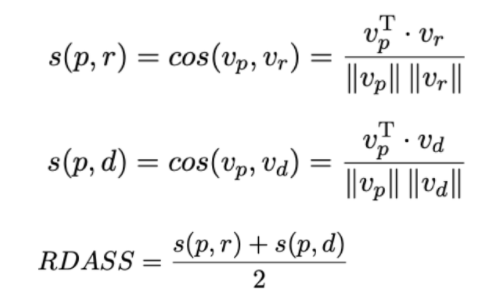
- Content와의 유사도, TItle과의 유사도 모두 고려하여 평균을 냄.
- 이는 본문과 의미, 제목과의 의미적 유사도가 모두 고려된 metric



Reference
- [RDASS - kakaoenterprise AI Research](https://kakaoenterprise.github.io/deepdive/210729)
- [klue-transformers github](https://github.com/Huffon/klue-transformers-tutorial)

In [ ]:
# sentence transformer library 설치

!pip install sentence_transformers


import torch 
from sentence_transformers import SentenceTransformer, util 

def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"# available GPUs : {torch.cuda.device_count()}")
        print(f"GPU name : {torch.cuda.get_device_name()}")
    else:
        device = torch.device("cpu")
    return device
device = set_device()

     |████████████████████████████████| 79 kB 9.4 MB/s 
     |████████████████████████████████| 3.8 MB 18.1 MB/s 
     |████████████████████████████████| 1.2 MB 77.3 MB/s 
     |████████████████████████████████| 67 kB 6.2 MB/s 
     |████████████████████████████████| 6.5 MB 64.0 MB/s 
     |████████████████████████████████| 596 kB 70.4 MB/s 
     |████████████████████████████████| 895 kB 93.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=05c2d358ce8c7a7ed16c78aa793b7ee6231e053316b470c29f51fb558e6529ef
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
# available GPUs : 1
GPU name : Tesla T4


In [ ]:
# 모델 불러오기
embed_model = SentenceTransformer("Huffon/sentence-klue-roberta-base")
embed_model.to(device)

# 임베딩 벡터 계산 예시
content = '마우리시오 포체티노 감독이 맨체스터 유나이티드 지휘봉을 잡으면 어떤 변화가 있을까. 영국 매체 ‘더 선’은 포체티노 감독 휘하에서 맨유가 꾸릴 수 있는 라인업을 공개했다. 새 얼굴 3명이 합류할 거로 전망했다. 4-2-3-1 포메이션의 최전방에는 해리 케인(토트넘 홋스퍼)이 위치했다. 2선은 변화가 없다. 크리스티아누 호날두, 브루누 페르난데스, 제이든 산초가 이름을 올렸다. 최전방 공격수를 소화하고 있는 호날두지만, 케인이 합류한다면 한 칸 내려설 거로 예상했다. 케인은 포체티노 감독의 애제자다. 2014년 포체티노 감독이 토트넘 지휘봉을 잡은 후 6년간 케인을 지도했다. 케인은 포체티노 감독의 지도 아래 ‘월드클래스’ 공격수로 발돋움했다. 예상 포메이션이지만, 케인이 이름을 올린 이유는 지난 여름 이적을 추진했기 때문으로 풀이된다. 케인은 우승을 원한다며 토트넘 퇴단을 외쳤으나 결국 잔류했다. 올 시즌 8경기에 나서 1골을 넣는 데 그쳤을 만큼 부진하다. 3선에는 칼빈 필립스(리즈 유나이티드), 마르코 베라티(파리 생제르맹)가 자리했다. 수비진과 수문장은 기존 선수들을 기용할 거로 봤다. 맨유는 그간 3선이 약하다는 평가를 받았다. 새 감독이 온다면, 보강은 필수다. 필립스는 잉글랜드 프리미어리그에서 가장 주목받는 미드필더 중 하나다. 리즈 핵심 선수이며 빼어난 수비력과 롱패스 능력이 장점으로 꼽힌다. 베라티 역시 PSG에서 중역을 맡고 있다. 볼 배급 및 간수 능력이 발군이다. PSG의 경기력에 큰 영향을 미치는 선수 중 하나다. 현재 맨유 수장 올레 군나르 솔샤르 감독의 경질설이 돌고 있다. 현지 다수 매체는 포체티노 감독을 후임으로 언급하고 있다.'
title = '포체티노가 맨유 간다면… ‘호날두·케인·산초’ 막강 스리톱+3선 변화'
output = '포체티노가 맨유 지휘봉을 잡으면 어떤 변화가 있을지, 맨유 라인업 공개... 호날두-산초-호날두-포체티노 라인업'

#768차원 벡터 생성
content_embedding = embed_model.encode(content)
title_embedding = embed_model.encode(title)
output_embedding = embed_model.encode(output)

# 유사도 측정
sim_title = util.pytorch_cos_sim(title_embedding, output_embedding)[0]
sim_content = util.pytorch_cos_sim(content_embedding, output_embedding)[0]
(sim_title.item()+ sim_content.item())/2 # 평균 출력

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.91k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/744 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/495k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

0.6910198032855988

In [ ]:
# !pip install sentence_transformers
# embedding을 위한 model 불러오기
import torch 
from sentence_transformers import SentenceTransformer, util 

embed_model = SentenceTransformer("Huffon/sentence-klue-roberta-base")
# module 이용을 위한 환경 변수 append
import sys
sys.path.append('/content/drive/MyDrive/[Wanted]기업과제4/')

## E. `metrics.py` module의 함수 설명

- `metric` : 최종 점수
- `metric_embed` : embedding similarity score 를 return
- `metric_rouge` : 한국어 형태소 gram화를 고려하여 rouge-1 f1 score 출력

### 성능 평가
1. `sim_score` : summary output이 얼마나 **본문 및 제목의 의미**를 잘 담아냈는가?(의미적 유사성)
2. `mor_score` : summary output과 제목의 **keyword 구성**이 유사한가? (형태소 기반 형태적 유사성(불용어 제외))

### 결론
1, 2 번 점수를 평균내어 의미적, 형태적 유사성을 종합적으로 평가하여 score 산정
- 자세한 사항은 모듈 내부 주석 및 상기 과정 참고

In [ ]:
%reload_ext autoreload
%autoreload 2 # 모든 모듈 reload
from metrics import metric, metric_embed, metric_rouge

content = '마우리시오 포체티노 감독이 맨체스터 유나이티드 지휘봉을 잡으면 어떤 변화가 있을까. 영국 매체 ‘더 선’은 포체티노 감독 휘하에서 맨유가 꾸릴 수 있는 라인업을 공개했다. 새 얼굴 3명이 합류할 거로 전망했다. 4-2-3-1 포메이션의 최전방에는 해리 케인(토트넘 홋스퍼)이 위치했다. 2선은 변화가 없다. 크리스티아누 호날두, 브루누 페르난데스, 제이든 산초가 이름을 올렸다. 최전방 공격수를 소화하고 있는 호날두지만, 케인이 합류한다면 한 칸 내려설 거로 예상했다. 케인은 포체티노 감독의 애제자다. 2014년 포체티노 감독이 토트넘 지휘봉을 잡은 후 6년간 케인을 지도했다. 케인은 포체티노 감독의 지도 아래 ‘월드클래스’ 공격수로 발돋움했다. 예상 포메이션이지만, 케인이 이름을 올린 이유는 지난 여름 이적을 추진했기 때문으로 풀이된다. 케인은 우승을 원한다며 토트넘 퇴단을 외쳤으나 결국 잔류했다. 올 시즌 8경기에 나서 1골을 넣는 데 그쳤을 만큼 부진하다. 3선에는 칼빈 필립스(리즈 유나이티드), 마르코 베라티(파리 생제르맹)가 자리했다. 수비진과 수문장은 기존 선수들을 기용할 거로 봤다. 맨유는 그간 3선이 약하다는 평가를 받았다. 새 감독이 온다면, 보강은 필수다. 필립스는 잉글랜드 프리미어리그에서 가장 주목받는 미드필더 중 하나다. 리즈 핵심 선수이며 빼어난 수비력과 롱패스 능력이 장점으로 꼽힌다. 베라티 역시 PSG에서 중역을 맡고 있다. 볼 배급 및 간수 능력이 발군이다. PSG의 경기력에 큰 영향을 미치는 선수 중 하나다. 현재 맨유 수장 올레 군나르 솔샤르 감독의 경질설이 돌고 있다. 현지 다수 매체는 포체티노 감독을 후임으로 언급하고 있다.'
title = '포체티노가 맨유 간다면… ‘호날두·케인·산초’ 막강 스리톱+3선 변화'
output = '포체티노가 맨유 지휘봉을 잡으면 어떤 변화가 있을지, 맨유 라인업 공개... 호날두-산초-호날두-포체티노 라인업'


# sim,mor score 와 final score
sim_score = metric_embed(content, title, output, embed_model)
mor_score = metric_rouge(content, title, output)

final_score = metric(content, title, output, embed_model)

print('***embedding similarity score is')
print(sim_score)

print('***ROUGE-1 f1 score is')
print(mor_score)

print('-----------------------------------')
print('***final score is')
print(final_score)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


# Korean stop words: 677
***embedding similarity score is
0.6910198032855988
***ROUGE-1 f1 score is
0.3870967741935484
-----------------------------------
***final score is
0.5390582887395736


- Wandb 를 이용하여 decoder hyperparameter tuning -> 매우 오랜 시간 소요로 인한 방법 변경

In [ ]:
# #!pip install wandb
# # api key 입력
# #!wandb login

# import wandb

# sweep_config2 = {
    
#     "name" : "wandb-evaluation",   
#     "method": "bayes",
#     "metric": {
#         "name" : "test_score", 
#         "goal" : "maximize"
#                 },
    
#     "parameters": { 
        
        
#         "max_length" : {
#             "distribution" : "categorical",
#             "values" : [60]
#         },
#         "length_penalty" : {
#             "distribution" : "categorical",
#             "values" : [2,1]
#         },
#         "num_beams" : {
#             "distribution" : "categorical",
#             "values" : [4,5]
#         },
#     },         
# }

In [ ]:
# def test(model, dataloader, wandb):
#     """
#     decoder 성능 측정
#     """
#     wandb.watch(model, log="all", log_freq = 10)

#     global embed_model

#     # model을 eval 모드로 설정 & device 할당
#     model.eval()
#     model.to(device)

#     w_config = wandb.config
    
#     # total_loss, batch_loss, batch_count =0, 0, 0
#     total_loss, total_score = 0, 0
#     try:
#       for step, batch in enumerate(dataloader):
#           # batch_count+=1
#           # batch_input을 device 할당
#           batch = tuple(item.to(device) for item in batch)
          
#           batch_tokenized, batch_label = batch

#           batch_input = {'input_ids' :batch_tokenized['input_ids'],
#                       'attention_mask' : batch_tokenized['attention_mask'],
#                       'labels' : batch_label['input_ids'] ,
#                       'decoder_attention_mask': batch_label['attention_mask']
#                       }
          
#           # gradient 계산하지 않고 forward 진행
#           with torch.no_grad():
            
#             loss = model(**batch_input)['loss']

#           # loss 값 추가 
            
#             total_loss+=loss.item()
#             summary_text_ids = model.generate(input_ids=batch_tokenized['input_ids'], 
#                       bos_token_id=model.config.bos_token_id, # beginning of sequence
#                         eos_token_id=model.config.eos_token_id, # end of sequence

#                         length_penalty=w_config.length_penalty, 
#                       max_length=w_config.max_length, # 결과문장 최대길이
#                       min_length=20, # 결과 문장 최소길이
#                       num_beams=w_config.num_beams,
                      
#                       )
            
#             output = tokenizer.decode(summary_text_ids[0], skip_special_tokens=True)
#             content = tokenizer.decode(batch_tokenized['input_ids'][0], skip_special_tokens=True)
#             title = tokenizer.decode(batch_label['input_ids'][0], skip_special_tokens=True)
#             if len(content)>800:
#               content = content[:800] # error debugging
#             final_score = metric(content, title, output, embed_model)
#             total_score +=final_score
#             # batch_loss+=loss.item()

#             # # 배치 10개씩 처리할 때마다 평균 loss를 출력
#             if (step % 10 == 0 and step != 0):
#                 print(f'****step number {step} is running.')  
#                 # batch_loss, batch_count = 0,0   
                
#           # all_labels.append(batch_label)
#     except IndexError:
#       print('index error') # Indexerror 나는 경우 제외
    
    
#     print(f"Test Loss : {total_loss/step:.4f}")
#     print(f'Test score : {total_score/step:.4f}')
    

#     wandb.log({'test_loss': total_loss/step})
#     wandb.log({'test_score': total_score/step})

#     return total_loss/step, total_score/step

In [ ]:
# def run_sweep2(config=None):
#   wandb.init(config = config)

#   test(model, test_dataloader, wandb)


# sweep_id2 = wandb.sweep(sweep_config2, project = "BART evaluation")
# wandb.agent(sweep_id2, run_sweep2, count = 4)

Create sweep with ID: 3y33haw1
Sweep URL: https://wandb.ai/crosstar/BART%20evaluation/sweeps/3y33haw1


wandb: Agent Starting Run: i2b4zrvl with config:
wandb: 	length_penalty: 1
wandb: 	max_length: 60
wandb: 	num_beams: 5


****step number 10 is running.
****step number 20 is running.


wandb: Ctrl + C detected. Stopping sweep.


# VI. Evaluation
- testing with hyperparameter tuning

## B. Hyperparameter tuning 2 : decoding with test_dataloader
### Metric : `metric` function in `metrics.py` module
- test set에 대한 loss 값은 이미 `tuning 1` 과정에서 결정됨.
- 설정된 평가지표 기반 가장 성능을 잘 낼수 있는 parameter 설정
- wandb 이용시 model.generate 연산이 함께 적용되기 때문에 매우 오랜 시간이 걸리는 것으로 판단됨.
- 단순 gridsearch를 이용


### tuning 결과
- length penalty : 2
- num_beams : 6

### length penalty는 2일때, num_beams 는 6일때 가장 score가 높다.
- 다만, beam 개수가 늘어날수록 시간이 오래 걸리는 단점이 있으므로 그 이상으로 선정하지 않음.
- length penalty 값이 3이 될 경우 필요 이상의 내용이 들어가는 것을 확인.

- max length 및 min length는 결과물 생성에 고려되는 변수가 아닌, 단순히 그 길이 이상 또는 이하일 경우 잘리는 변수이므로 tuning에 고려하지 않음.

In [ ]:
def test_by_gridsearch(model, dataloader, length_penalty_value, num_beams_value):
    """
    test set 2000개로 decoder 성능 측정(생성한 Metric 기반)
    """

    global embed_model

    # model을 eval 모드로 설정 & device 할당
    model.eval()
    model.to(device)
    
    # total_loss, batch_loss, batch_count =0, 0, 0
    total_loss, total_score = 0, 0
    try:
      for step, batch in enumerate(dataloader):
          # batch_count+=1
          # batch_input을 device 할당
          batch = tuple(item.to(device) for item in batch)
          
          batch_tokenized, batch_label = batch

          batch_input = {'input_ids' :batch_tokenized['input_ids'],
                      'attention_mask' : batch_tokenized['attention_mask'],
                      'labels' : batch_label['input_ids'] ,
                      'decoder_attention_mask': batch_label['attention_mask']
                      }
          
          # gradient 계산하지 않고 forward 진행
          with torch.no_grad():
            
            loss = model(**batch_input)['loss']

          # loss 값 추가 
            
            total_loss+=loss.item()
            summary_text_ids = model.generate(input_ids=batch_tokenized['input_ids'], 
                      bos_token_id=model.config.bos_token_id, # beginning of sequence
                        eos_token_id=model.config.eos_token_id, # end of sequence
                        
                        length_penalty=length_penalty_value, 
                      max_length=60, # 결과문장 최대길이
                      min_length=20, # 결과 문장 최소길이
                      num_beams=num_beams_value,
                      
                      )
            
            output = tokenizer.decode(summary_text_ids[0], skip_special_tokens=True)
            content = tokenizer.decode(batch_tokenized['input_ids'][0], skip_special_tokens=True)
            title = tokenizer.decode(batch_label['input_ids'][0], skip_special_tokens=True)
            if len(content)>800:
              content = content[:800] # error debugging
            final_score = metric(content, title, output, embed_model)
            total_score +=final_score
            # batch_loss+=loss.item()

            # # 배치 10개씩 처리할 때마다 평균 loss를 출력
            if (step % 10 == 0 and step != 0):
                print(f'****step number {step} is running.')  
                # batch_loss, batch_count = 0,0   
                
          # all_labels.append(batch_label)
    except IndexError:
      print('index error') # Indexerror 나는 경우 제외
    print(f'Hyperparameter : length_penalty : {length_penalty_value} , num_beams : {num_beams_value} ')
    
    print(f"Test Loss : {total_loss/step:.4f}")
    print(f'Test score : {total_score/step:.4f}')
    print('********Content, title, output is below')
    print(f'CONTETNT : {content}')
    print(f'TITLE : {title}')
    print(f'OUTPUT : {output}')

    

    return total_loss/step, total_score/step

In [ ]:
# Grid Search로 Testset score 차이 확인

length_penalty_list = [0.5, 2,3]
num_beams_list = [4,5,6]

for length_penalty_value in length_penalty_list:
  for num_beams_value in num_beams_list:
    test_by_gridsearch(model, test_dataloader, length_penalty_value, num_beams_value)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


****step number 10 is running.
****step number 20 is running.
****step number 30 is running.
****step number 40 is running.
****step number 50 is running.
****step number 60 is running.
Hyperparameter : length_penalty : 0.5 , num_beams : 4 
Test Loss : 1.8573
Test score : 0.4810
********Content, title, output is below
CONTETNT : 오재석(인천 유나이티드)의 궁극적인 목표는 팀의 아시아축구연맹(AFC) 챔피언스리그(ACL) 진출이다. 인천의 파이널A, ACL 진출을 위해 농담조로 친한 동료들에게 이적을 제안하기도 한다. 그간 인천의 성적, 현재 선수 구성을 생각하면 당장은 ACL 진출이 어려운 게 사실이다. 하지만 오재석은 ACL 진출이 막연한 꿈이라고 생각하지 않는다. 시민구단 대구FC가 해왔던 것처럼 차근차근 단계를 밟는다면 가능하다고 본다. 올 시즌 반전의 신호탄을 계기로 파이널A에 진출하고, FA컵에서 우승까지 한다면 경쟁력 있는 팀이 될 거라고 굳게 믿는다. 오재석은 본인의 은퇴 전, 인천이 ‘아시아 무대’를 누비는 모습을 꿈꾼다.    
TITLE : “김영권에게 인천 오라고 했는데”... 시민구단 최고의 목표는 'ACL'
OUTPUT : 인천FC 오재석 “ACL 진출이 막연한 꿈 아니다, 차근차근 단계 밟는다면 가능”
****step number 10 is running.
****step number 20 is running.
****step number 30 is running.
****step number 40 is running.
****step number 50 is running.
****step number 60 is running.
Hyperparameter : length_pena

In [ ]:
length_penalty_list = [1]
num_beams_list = [5,6]

for length_penalty_value in length_penalty_list:
  for num_beams_value in num_beams_list:
    test_by_gridsearch(model, test_dataloader, length_penalty_value, num_beams_value)

****step number 10 is running.
****step number 20 is running.
****step number 30 is running.
****step number 40 is running.
****step number 50 is running.
****step number 60 is running.
Hyperparameter : length_penalty : 1 , num_beams : 5 
Test Loss : 1.8573
Test score : 0.4848
********Content, title, output is below
CONTETNT : 오재석(인천 유나이티드)의 궁극적인 목표는 팀의 아시아축구연맹(AFC) 챔피언스리그(ACL) 진출이다. 인천의 파이널A, ACL 진출을 위해 농담조로 친한 동료들에게 이적을 제안하기도 한다. 그간 인천의 성적, 현재 선수 구성을 생각하면 당장은 ACL 진출이 어려운 게 사실이다. 하지만 오재석은 ACL 진출이 막연한 꿈이라고 생각하지 않는다. 시민구단 대구FC가 해왔던 것처럼 차근차근 단계를 밟는다면 가능하다고 본다. 올 시즌 반전의 신호탄을 계기로 파이널A에 진출하고, FA컵에서 우승까지 한다면 경쟁력 있는 팀이 될 거라고 굳게 믿는다. 오재석은 본인의 은퇴 전, 인천이 ‘아시아 무대’를 누비는 모습을 꿈꾼다.    
TITLE : “김영권에게 인천 오라고 했는데”... 시민구단 최고의 목표는 'ACL'
OUTPUT : 인천ACL 진출 꿈꾸는 오재석, “FA컵 우승까지 한다면 경쟁력 있는 팀이 될 것”
****step number 10 is running.
****step number 20 is running.
****step number 30 is running.
****step number 40 is running.
****step number 50 is running.
****step number 60 is running.
Hyperparameter : length_penal

## C. 10,000 summarized text Generation(to CSV file)
- 검증된 hyperparameter를 통해 dataset의 기사 본문에 대한 요약 생성

In [ ]:
import csv
# inference output 파일 csv 파일로 저장하는 코드
def summarized_sentences(dataset):
  savepath = '/content/drive/MyDrive/[Wanted]기업과제4/summarized_news_data.csv'
  with open (savepath, 'w', newline='\n') as f:
    wr = csv.writer(f)
    wr.writerow(['index','summary'])
    for i in range(len(dataset)):
      # try:
        tokenized_id = tokenizer.encode(dataset[i][0],return_tensors="pt").to(device)
        summary_text_ids = model.generate(input_ids=tokenized_id, 
                      bos_token_id=model.config.bos_token_id, # beginning of sequence
                        eos_token_id=model.config.eos_token_id, # end of sequence
                        length_penalty=2.0, # exponential penalty. 1.0 은 penalty 없음. 1보다 크면 더 긴 문장 생성하고, 1보다 작으면 더 작은 문장 생성
                      max_length=60, # 결과문장 최대길이
                      min_length=20, # 결과 문장 최소길이
                      num_beams=6,# beam search 시 beam 개수(고려할 확률값이 상위 rank인 가짓수. 값이 높을수록 시간이 오래걸리지만 최적해를 찾아낼 가능성이 높아짐.
                      
                      )
        del tokenized_id # gpu memory 공간을 이용하는 tensor 삭제
        summarized = tokenizer.decode(summary_text_ids[0], skip_special_tokens=True)
        if i%1000==0:
          print(f'***{i}th summary was written:{summarized}')
        wr.writerow([i+1,summarized])
    print('-----------summary of csv file made succesfully.------------')
      # except RuntimeError:
      #   print('Error occured')
      #   wr.writerow([i+1,'Blank'])

In [ ]:
summarized_sentences(dataset)

***0th summary was written:“스스널, 토트넘이 UCL 진출 유력” 아스널 레전드의 전망
***1000th summary was written:레노버-인터 밀란 파트너십 강화... 유니폼 뒷면 하단에 레노버 로고 새긴다
***2000th summary was written:아케본라허, “케인, 토트넘 훈련장 복귀 안 했어”... “이적 위해 협박했어”
***3000th summary was written:‘조규성 발탁’ 벤투호, 손흥민-황의조 대신 황희찬-조규성 선발 출격... 최종예선 마지막 단계
***4000th summary was written:‘이적설 제조기’ 포그바, 맨유와 장기 동행 원한다... “계약 연장 원해”
***5000th summary was written:'트트트릭 폭발' 괴물 공격수 '올해만 27골'...토트넘이 영입했어야
***6000th summary was written:콘테, 세리에A 시절 눈여겨봤던 MF 영입 수락... 밀란과 ‘머니게임’ 
***7000th summary was written:안산그리너스FC, K리그 레전드 신화용 코치로 영입..."지도자로서도 우승컵 들어보고 싶다"
***8000th summary was written:인도네시아 팬들의 열렬한 지지, 신태용 감독 계속 감독직 수행 원한다..."다음 대회에선 틀림없이 우승할 수 있도록 하겠다"
***9000th summary was written:‘울산은 좋은 곳’ 김기희, 불투이스와 재회... “올해도 최선 다해 우승 도전”
***10000th summary was written:'중국 비하 논란' 케네디, 1480일 만에 첼시 복귀전 노린다 (英 매체)
-----------summary of csv file made succesfully.------------


# VII. Results & Discussion

In [ ]:
# 결과물 확인
import pandas as pd
import csv

df_sum = pd.read_csv('/content/drive/MyDrive/[Wanted]기업과제4/summarized_news_data.csv')

df_sum.head()

,index,summary
0,1,"“스스널, 토트넘이 UCL 진출 유력” 아스널 레전드의 전망"
1,2,"‘ 데뷔골’ 이승우, 6경기 만에 K리그 데뷔골 작렬...대구에 4-3 승"
2,3,"첼금융그룹과 손잡고 첼시 인수에 뛰어든 英 재벌, “아버지 유골 경기장에 뿌렸어”"
3,4,"“매과이어가 왜 뽑혔어?”...사우스게이트, “왜 매과이어를 뽑은 거지, 이해가 안 돼”"
4,5,"포포체티노, 올여름 토트넘 복귀 고려... “콘테 감독 거취 중요” (英 매체)"


In [ ]:
df_sum.isnull().sum()

index          0
summary        0
sim_score      0
mor_score      0
final_score    0
dtype: int64

In [ ]:
df.head()

,content,title,PUBLISH_DT,content_len,title_len,sum_ratio,content_len_
0,어느 때보다 잘나가는 아스널. 그러나 구단 전설은 라이벌 토트넘 홋스퍼가 마지막에 ...,"진심인가? 아스널 전설 “토트넘이 TOP4, 아스널은 갈 길 멀어”",2022-03-20,148,9,0.060811,148
1,수원FC 이승우가 6경기 만에 K리그 데뷔골을 신고했다. \r수원FC는 20일 오후...,"‘데뷔골+춤사위’ 이승우, 서서히 타오르고 있다",2022-03-20,256,5,0.019531,256
2,하나금융그룹과 손잡고 첼시 인수에 뛰어든 영국 부동산 재벌 닉 캔디의 남다른 첼시 ...,“아빠 유골 첼시 구장에 뿌려” 하나금융과 손잡은 英 재벌의 '미친 일화',2022-03-20,175,11,0.062857,175
3,해리 매과이어(맨체스터 유나이티드)의 국가대표팀 승선 소식에 말이 많다.\r가레스 ...,‘경기 안봐?’ 매과이어 국대 발탁에 의문 폭발… 英 감독 “빠질 이유 없어...,2022-03-20,229,12,0.052402,229
4,마우리시오 포체티노 파리 생제르맹 감독이 토트넘 홋스퍼에 복귀할 수 있다는 보도가 ...,3년 만에 SON과 재회? “토트넘으로 로맨틱한 복귀 원할 것”,2022-03-20,208,9,0.043269,208


In [ ]:
# 길이 일치 여부 확인
len(df_sum), len(df)

(10033, 10033)

### A. 에러 방지
- 유사도 측정(`SentenceTransformer`) 시 모델 최대 input 길이를 초과할 경우, error 가 나므로 방지해주는 작업 필요(800~900으로 추정)
- BART model 학습을 위한 Truncating 작업과 별개(토큰 수가 아닌 string의 길이 자체가 800 아래여야 함)
- 평균적으로 BART Tokenizer의 개수의 2배가 string length이므로, 모델 설정시 썼던 400의 두배인 800으로 잘라내어 embedding vector 추출

In [ ]:
# model 
def truncate(x):
  length=len(x)
  if length>=800:
    x= x[:800]
  return x
df['content'] = df.content.apply(truncate) # truncate 함수 적용
len(df.content[26])

725

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
# metric 기반하여 모든 dataset에 대해 score 생성
from metrics import metric, metric_embed, metric_rouge

sim_score_list=[]
mor_score_list=[]
final_score_list=[]
num_data = len(df)
for i in range(num_data):
  content= df.content[i]
  title= df.title[i]
  output= df_sum.summary[i]
  # print(i)
  sim_score = metric_embed(content, title, output, embed_model)
  mor_score = metric_rouge(content, title, output)
  final_score = (sim_score+ mor_score)/2 # metric 함수를 이용하면 같은 연산을 여러번 하는 것이므로, 별도로 평균을 내었다.
  sim_score_list.append(sim_score)
  mor_score_list.append(mor_score)
  final_score_list.append(final_score)

df_sum['sim_score'] = sim_score_list
df_sum['mor_score'] = mor_score_list
df_sum['final_score'] = final_score_list
df_sum.head()

,index,summary,sim_score,mor_score,final_score
0,1,"“스스널, 토트넘이 UCL 진출 유력” 아스널 레전드의 전망",0.645086,0.190476,0.417781
1,2,"‘ 데뷔골’ 이승우, 6경기 만에 K리그 데뷔골 작렬...대구에 4-3 승",0.595293,0.250000,0.422646
2,3,"첼금융그룹과 손잡고 첼시 인수에 뛰어든 英 재벌, “아버지 유골 경기장에 뿌렸어”",0.671421,0.416667,0.544044
3,4,"“매과이어가 왜 뽑혔어?”...사우스게이트, “왜 매과이어를 뽑은 거지, 이해가 안 돼”",0.531397,0.166667,0.349032
4,5,"포포체티노, 올여름 토트넘 복귀 고려... “콘테 감독 거취 중요” (英 매체)",0.528572,0.190476,0.359524


## B. 측정 결과
- sim_score : 평균 0.6, mor_score 평균 0.3, final score 평균 0.45
- Training /Validation set을 분리하여 성능 확인 결과 통계량에서 유의미한 차이를 보이지 않음. 
- 각각 left, right skewed data 형태이고 평균낸 final score는 정규분포곡선과 가까운 형태를 나타냄. 
-sim_score 와 mor_score 사이의 correlation은 0.6으로, 상관관계가 어느정도 있지만 차이가 있음. 
  - 이는 의미적으로 유사한 것이 어느 정도 형태적으로도 유사하다는 것을 의미.
  - 하지만 분리해서 고려할 필요가 없을만큼 강한 상관관계는 아님.

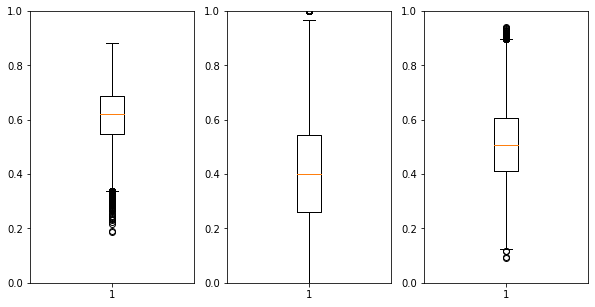

In [ ]:
# 분포 확인
fig, axes = plt.subplots(1,3, figsize = (10,5))
axes[0].boxplot(df_sum['sim_score'])

axes[1].boxplot(df_sum.mor_score)
axes[2].boxplot(df_sum.final_score)
for ax in axes:
  ax.set_ylim([0, 1])
plt.show()

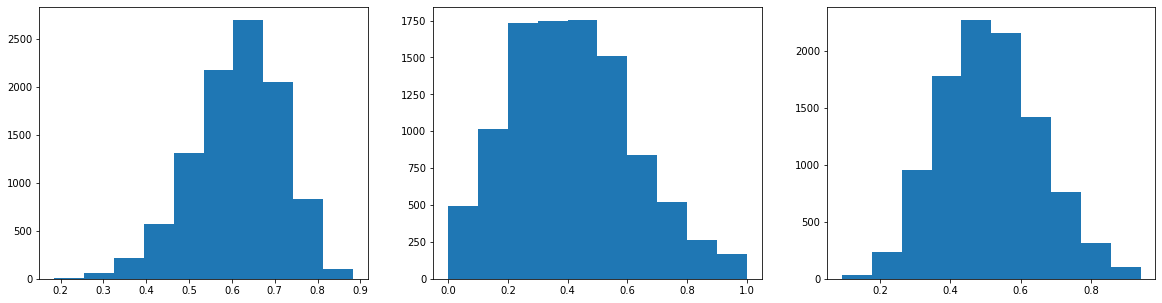

In [ ]:
# 히스토그램 확인
fig, axes = plt.subplots(1,3, figsize = (20,5))
axes[0].hist(df_sum.sim_score)

axes[1].hist(df_sum.mor_score)
axes[2].hist(df_sum.final_score)

plt.show()

In [ ]:
# 상관계수 측정
df_sum.sim_score.corr(df_sum.mor_score)

0.6661480195029496

In [ ]:
df_sum.describe()[['sim_score', 'mor_score', 'final_score']]

,sim_score,mor_score,final_score
count,10033.000000,10033.000000,10033.000000
mean,0.612579,0.413397,0.512988
std,0.103405,0.203080,0.141343
min,0.185607,0.000000,0.092804
25%,0.547337,0.260870,0.412617
50%,0.621578,0.400000,0.506593
75%,0.686160,0.545455,0.606134
max,0.882284,1.000000,0.941142


### 1) Two-sample t-test
*귀무가설 : 두 sample 간 통계량에 차이가 있다. 
  - t value 99 이상으로 매우 큰 수치
  - P(t>99.39) <<< 0.05 by t-value table (P(t>1.645)=0.05) 
  - sample 수(자유도) 가 충분히 크므로 z-score와 같이 연산해도 무방.

신뢰도 95%에 기반하였을 때, 두 샘플 간 성능의 차이가 없다고 결론.
-> 학습이 적절히 진행되었으며 과적합되지 않은, 일반화 성능을 보인다.

In [ ]:
# Trainin set 결과
len_train = int(len(dataset)*8/10)
len_val = len(dataset)-len_train
df_sum[:len_train].describe().loc['mean', ['sim_score', 'mor_score', 'final_score']]

sim_score      0.611409
mor_score      0.411957
final_score    0.511683
Name: mean, dtype: float64

In [ ]:
#Test set 결과
df_sum[len_train:].describe().loc['mean', ['sim_score', 'mor_score', 'final_score']]

sim_score      0.617259
mor_score      0.419155
final_score    0.518207
Name: mean, dtype: float64

## C. 평가지표에 대한 평가 : score 비교 및 확인
- mor_score 가 1인 결과물을 비교한 결과, 매우 성공적인 요약을 확인할 수 있음.
- 유사도 점수가 떨어지는 output으로 비교 결과, 의미적으로 다른 내용이 나온 것을 확인할 수 있음.(본문 및 제목은 부상을 이겨내고 활약했다는 긍정적인 내용이지만, 요약문에서는 반대로 부정적인 내용을 내포하고 있음. )

- 결과적으로 요약본이 본문 및 제목의 의미를 잘 담고있는지를 표현하는 **보다 합리적인 지표로** 판단됨. 

In [ ]:
# final score 0.9 이상인 것들 확인
df_sum[df_sum.final_score>0.9]

,index,summary,sim_score,mor_score,final_score
44,45,"‘김문환 K리그 복귀’ LAFC, 전북 이적 공식 발표... “함께해줘서 고마워”",0.864111,0.956522,0.910316
164,165,"“머리가 커서 공을 잘 따내~"" 맨유 팬들을 당황케 한 해설자의 조롱",0.802823,1.000000,0.901412
178,179,"PSG, 네이마르 판매 움직임... “바르사와 몇몇 구단에 제안”",0.850762,1.000000,0.925381
273,274,‘붙잡고는 싶은데...그 정도 금액은 힘들어’ 리버풀 구단주의 고민,0.820588,1.000000,0.910294
279,280,“하늘에서 떨어진 선물...본보기” 바르셀로나 공격수의 ‘입지변화’,0.826263,1.000000,0.913131
304,305,"지예흐, 모로코 대표팀 완전 은퇴 선언...""날 악의적으로 대했다""",0.840228,1.000000,0.920114
309,310,"'이제 나가' PSG, 올 시즌 끝으로 포체티노 경질→후임은 지단",0.832567,1.000000,0.916284
310,311,살라 재계약 불발 되어도 EPL 잔류 원한다...라이벌 팀 이적 가능성↑,0.850499,1.000000,0.925250
473,474,"OK금융그룹 레오, V-리그 5라운드 남자부 MVP 선정",0.859397,1.000000,0.929699
587,588,"'리버풀 출신 모여라' 제라드의 빌라, 코치뉴 이어 바이날둠 영입 관심",0.834832,1.000000,0.917416


In [ ]:
idx = 9689
df.content[idx], df.title[idx], df_sum.summary[idx]

('[스포탈코리아] 김진선 기자= 프랭크 램파드가 에버턴 감독으로 잉글랜드 프리미어리그(EPL)로 돌아온다.\n\n에버턴은 31일(한국시간) 구단 공식 홈페이지를 통해 “램파드 감독과 2024년 6월까지 2년 반 계약을 체결했다. 2월 5일 구디슨 파크에서 열리는 브렌트포드와의 FA컵 4라운드 경기에서 감독 데뷔전을 치를 예정”이라고 발표했다.\n\n올 시즌 최악의 부진을 겪은 에버턴(승점 19)은 현재 리그 16위에 위치해있다. 강등권과 승점 단 4점차를 기록 중이다. \n\n라파엘 베니테즈 감독을 경질 시킨 에버턴은 던컨 퍼거슨 수석코치를 임시감독으로 앉혔다. 이후 빠르게 감독 후보를 물색했다. 당초 웨인 루니가 유력한 차기 감독직 후보로 꼽혔다. 하지만 그가 더비 카운티에 남을 의사를 전하며 에버턴의 최종 선택은 램파드다. \n\n램파드는 지난 2016년 선수 생활을 마친 뒤 첼시 아카데미 코치로 지도자 생활을 시작했다. 2018년부터 더비 카운티 지휘봉을 잡은 램파드는 좋은 성과를 거둬 감독으로서 능력을 인정받았다.\n\n이듬해 7월 램파드는 친정팀 첼시 사령탑에 올랐다. 부임 첫 시즌부터 유럽축구연맹(UEFA) 챔피언스리그(UCL) 진출 성공이라는 쾌거를 달성했다. 하지만 이듬해 첼시는 극심한 부진에 빠졌고, 결국 그는 1년 반 만에 첼시 감독직에서 내려왔다.\n\n첼시를 떠나고 1년만의 EPL 복귀다. 램파드 감독은 “전통을 지닌 클럽을 대표하고 관리하는 것에 큰 영광이라고 생각한다. 에버턴 수뇌부들과 이야기를 나눈 후 그들의 열정에 감명받았다. 또 팬들의 열정에도 매우 놀랐다. 그들이 나의 야망을 느낄 수 있도록 열심히 해보겠다”며 소감을 전했다.\n\n사진=에버턴 구단 공식 홈페이지',
 '[오피셜] 램파드, 에버턴 감독으로 EPL 복귀... 2024년까지 계약',
 '램파드, 에버턴 감독으로 EPL 복귀...2024년까지 계약')

In [ ]:
# mor score 0 확인
df_sum[df_sum.mor_score==0]

,index,summary,sim_score,mor_score,final_score
52,53,"‘유리몸’ 린가드, 밀란-로마행 유력... 올여름 이적료 없이 떠난다",0.584973,0.0,0.292487
146,147,"베토, 라미레즈 영입 원하나... 클리블랜드, ‘2년 계약+30홈런+2년’ 옵션 포함",0.504187,0.0,0.252094
156,157,"“손흥민, 80분간 팀 내 최다 키패스...” 이브닝 스탠다드, 팀 내 최하 평점 4점",0.335169,0.0,0.167585
209,210,“코로나바이러스가 호랑이굴 덮쳤어” 울산 관계자의 풀죽,0.314487,0.0,0.157244
453,454,"메이저리그 역대 최장 기간 직장폐쇄, 드디어 복귀... “선수노조, 승인도 승인” ...",0.562352,0.0,0.281176
...,...,...,...,...,...
9576,9577,"‘충격’ 애슐리 영, 뉴캐슬 관심 거절... “계속 남고 싶다는 의사 전달” (英 매체)",0.505779,0.0,0.252889
9601,9602,'트라오레-디아스-블라호비치 모두 실패' 토트넘 1월 이적 시장 실패,0.358998,0.0,0.179499
9679,9680,"토트넘 MK 돈스 올해의 선수-풋볼 리그 영 플레이어...알리, 발렌시아행 유력",0.436139,0.0,0.218069
9734,9735,알알-판 더 비크-조던 픽포드- 히샬리송... 에버턴 후반기 예상 라인업,0.394986,0.0,0.197493


In [ ]:
idx = 9735
df.content[idx], df.title[idx], df_sum.summary[idx]

('[스포탈코리아] 곽힘찬 기자= 델레 알리(에버턴)가 자신을 키워준 토트넘 홋스퍼를 향해 감사함이 담긴 작별 인사를 보냈다.\n\n영국 매체 ‘더 선’은 1일(현지시간) “알리는 자신의 SNS 계정을 통해 토트넘에서의 시간이 행복했다는 작별 인사를 남겼다. 또한 포체티노를 향한 감사의 말도 잊지 않았다”라고 전했다.\n\n에버턴은 최근 공식 홈페이지를 통해 “토트넘 미드필더 알리와 2024년 6월 말까지 2년 6개월 계약을 맺었다”라고 발표했다.\n\n알리는 한때 토트넘에서 손흥민, 해리 케인, 크리스티안 에릭센(브렌트포드)과 함께 ‘DESK’ 라인을 결성해 잉글리시 프리미어리그(EPL) 무대를 휘어잡았을 정도로 뛰어난 선수였다. 하지만 2018/2019시즌을 기점으로 갑작스럽게 경기력이 추락하더니 포체티노가 떠난 이후론 완전히 다른 선수가 됐다.\n\n이후부터 철저하게 벤치 자원으로 분류됐다. 안토니오 콘테 감독이 지휘봉을 잡아도 마찬가지였다. 결국 알리는 뛰기 위해 토트넘을 떠나기로 결심했고 에버턴에 새롭게 부임한 프랭크 램파드 감독과 함께 하기로 결정했다.\n\n협상은 빠르게 이뤄졌고 이적시장 마감을 앞두고 알리의 에버턴 완전 이적이 성사됐다. 정들었던 토트넘과의 결별, 알리도 정말 아쉬웠다. 비록 마지막은 그리 좋은 인상을 주지 못했지만 자신을 키워준 팀이기에 씁쓸할 수밖에 없었다.\n\n알리는 자신의 SNS를 통해 “에버턴 이적은 챕터의 끝이지만 이야기의 끝은 아니다. 토트넘에서 놀라운 7년을 보냈고 새로운 가족과 다름없는 평생 친구를 만들었다. 난 내 형제들이 남은 시즌을 잘 보내길 바란다”라고 언급했다.\n\n이어 “팬들에게 고맙다는 말을 하고 싶다. 팬들을 위해 뛰는 꿈이 현실이 됐고 여러분들은 항상 내 마음 속에 있을 것이다. 포체티노에게도 감사하다. 그는 내가 토트넘에서 커리어를 시작할 때 내게 자신감을 줬고 내가 무엇을 할 수 있는지 가르쳐 준 분이다”라고 덧붙였다.\n\n사진=게티이미지코리아',
 '\'SON 절친\' 알리의 작별 인사,

In [ ]:
# sim score 낮은 것들 확인
df_sum[df_sum.sim_score<0.3]

,index,summary,sim_score,mor_score,final_score
113,114,"‘이건희’ 향한 이정효 감독, “동계훈련 동안 내 장점 극대화 시켰다”",0.294340,0.083333,0.188837
177,178,"스닉스의 작심비판, “랑닉, 콘테-투헬했어야 해”",0.241793,0.166667,0.204230
264,265,‘키스 가보자!’ 카이너-팔레파가 트레이드... “#2처럼 되고 싶어요!”,0.297950,0.320000,0.308975
542,543,“감독은 한 명의 선수 때문에 위험을 감수해선 안 돼” 前 콜롬비아 지도자의 애정어...,0.270848,0.000000,0.135424
579,580,바바메양-트라오레 3인방 믿는 ‘성공한 덕후’... “차비 체제서 힘들 것”,0.289809,0.086957,0.188383
840,841,"‘성공적’ 기성용, “후배 이한범도 잘 싸워 막아준 것 같다”",0.297809,0.181818,0.239813
1030,1031,"‘종종차별’ 사카, 인스타그램에 “마커스, 제이든이 받은 상처는 아이, 어른 할 것...",0.291007,0.160000,0.225504
1079,1080,"‘올림픽 와일드카드’ 박지수, “서두르지 않고 적응할 수 있게 도와드리겠다”",0.247344,0.071429,0.159386
1987,1988,"‘울산의 돌풍’ 양주 박성배 감독, “큰 부상 없어 감사, 상위 리그 더 많이 가길...",0.289769,0.230769,0.260269
2425,2426,"‘무득점’ 광주 김주공, “3연승 못 해...조나탄 오면 플러스”",0.287997,0.160000,0.223999


In [ ]:
df.content[3371], df.title[3371], df_sum.summary[3371]

('[스포탈코리아] 황의조(지롱댕 드 보르도)가 자신에게 붙었던 우려의 시선을 떨쳐내고 비상했다.\n\n황의조는 19일 오전 4시(한국시간) 프랑스 생테티엔의 조프루아 기샤르에서 열린 2021/2022 프랑스 리그앙 6라운드 생테티엔과의 원정 경기에서 2골을 터뜨리며 팀의 2-1 승리를 이끌었다.\n\n2연패와 함께 5경기 연속 무승(2무 3패) 고리를 끊은 보르도(승점 5점)는 리그 최하위에서 탈출했다.\n\n이날 황의조의 출전 여부에 관심이 쏠렸다. 황의조는 직전 경기에서 강행군에 발목 잡혔다. A대표팀에서도 컨디션이 정상이 아니라고 알려졌던 황의조는 지난 라운드 RC 랑스전에서 64분 만에 교체됐다.\n\n피로도 때문이었다. 후반전 초반부터 근육 경련이 일어나더니 결국 그라운드에 주저앉았다. 인상을 찌푸리며 제대로 걷지 못하는 모습에 부상 가능성까지 제기됐다.\n\n그러나 생테티엔전을 앞두고 블라디미르 페트코비치 감독은 황의조에 대해 “시차와 비행, 잠을 못 잔 게 원인이었던 거 같다. 팀 훈련 때 배려했고 다시 싸울 준비가 됐다”라며 출전을 예고했다.\n\n황의조는 이날도 보르도의 최전방에 섰다. 그러고선 자신을 향한 우려의 시선을 안다는 듯 킥오프 휘슬과 동시에 전력 질주하며 상대를 압박했다.\n\n기다렸던 첫 골도 일찍 터지며 어깨를 가볍게 했다. 전반 7분 야신 아들리의 패스를 받아 차분하게 밀어 넣으며 시즌 첫 골을 기록했다.\n\n선제골 이후에도 황의조는 활발했고 날카로웠다. 머리와 양발 모두 가리지 않았다. 전반 33분에는 티모시 펨벨레의 크로스를 다이빙 헤더로 연결했지만, 살짝 빗나갔다.\n\n후반 7분에는 팬텀 드리블로 불리는 라 크로게타로 상대 수비를 제친 뒤 오른발 슈팅을 시도했지만, 골키퍼 선방에 걸렸다.\n\n그라운드 곳곳에 물이 고일 정도로 내리는 폭우에도 추가골을 넣으려는 황의조의 분투는 이어졌다. 후반 19분 다시 한번 펨벨레의 크로스가 황의조를 향했지만 바운드 뒤 빨라진 공의 타이밍을 잡지 못했다.\n\n아쉬움은 오래가지 않

## D. 결과물 저장
- 기사 요약 파일(.xlsx or .csv)
    - 파일명: 기업과제4_0팀_sports_news_data.xlsx(or .csv)
    - sports_news_data.csv 파일("[중요] 기업 과제 설명 및 데이터" 게시글의 첨부파일)에 다음 column을 추가해 제출
        - “TRUE SUMMARY” : 팀에서 정의한 ground truth 요약 (정답셋으로 사용할 예정) [str]
        - “PREDICT SUMMARY” : 학습 모델로 “CONTENT”를 요약한 결과 [str]
        - “SCORE” : 팀이 정의한 매트릭으로 계산한 요약 텍스트 스코어 [float|int]


In [ ]:
# 제출 파일 생성 및 제출
df_for_submission = df_for_submission[['title', 'content','PUBLISH_DT']]
df_for_submission['TRUE SUMMARY'] = df_for_submission.title

df_final = pd.concat([df_for_submission,  df_sum[['summary', 'final_score']]],axis=1)

df_final.columns = ['TITLE', 'CONTENT','PUBLISH_DT', 'TRUE SUMMARY','PREDICT SUMMARY', 'SCORE']

df_final.to_csv('/content/drive/MyDrive/[Wanted]기업과제4/기업과제4_2팀_sports_news_data.csv',
              index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_final[['TRUE SUMMARY', 'PREDICT SUMMARY', 'SCORE']].sample(10)

,TRUE SUMMARY,PREDICT SUMMARY,SCORE
7587,"부폰의 속마음, ""유벤투스, 개인주의 호날두 때문에 팀 DNA 잃었어""","부폰, ""호날두가 유벤투스 유럽 무대 제패 방해했다""",0.515607
9524,"황의조-조규성, 찰떡 호흡… ‘SON 없는’ 벤투호의 믿을만한 플랜B","‘손흥민 없는’ 벤투호, 조규성-조규성+황의조 투톱 성공...벤투호 ‘플랜B는 성공적’",0.609162
4884,"‘영원한 대전의 아들’ 황인범, 홈 경기 관람 지원하며 선한 영향력 전파","‘대전의 아들’ 황인범, 대전하나시티즌의 정규리그 마지막 홈경기 함께... 친정 사...",0.468407
206,"[UCL 16강 ②] '심판이 지배했다' 맨유, 아틀레티코에 0-1 패배...'8강...","‘유리몸’ 맨유, 아틀레티코에 0-1 충격패... 8강행 좌절",0.675734
5341,"맨더비 통합 베스트11 공개…""생각보다 맨유 많은데"" 의문 제기","맨더비 통합 베스트11 공개...맨유-맨시티, 맨유 통합 베스트11",0.542511
5880,"'굿바이' 솔샤르, 48시간 내로 경질 확정...'대체자는 로저스'",'솔샤르 경질'...맨유 보드진도 결단 내렸다...'대체자는 로저스',0.535790
3764,"20살 신입생 향한 토트넘의 기대, “제2의 다비드 실바 될 수 있다”","토스 유망주 향한 토트넘의 기대, “제2의 다비드 실바 될 수 있다”",0.707293
6329,"[EPL 14R] '손흥민 크로스→자책골 유도' 토트넘, 브렌트포드에 1-0 리드 ...","‘손흥민 선제골’ 토트넘, 브렌트포드에 1-0 리드 (전반 종료)",0.752767
5721,"""돌진하는 황희찬, 강력한 위협""…전력 향상시킨 영입 TOP5","황희찬, EPL 성공적 영입생 TOP5 포함...""황희찬이 라울 히메네스에게 숨통을...",0.454607
4479,"2년 전 축구선수 사망 사고 피고인, 재판 앞두고 무면허 혐의 인정","‘무면허→무면허’ 살라 추락 사고 피고인, 기소 내용 중 1개 인정",0.398463


## E. 회고
- 1000개의 data가 결과물에 추가되었다. 
- abstractive summarization task였기 때문에, 제목을 TRUE SUMMARY로 그대로 활용하여 pretrained 성능에 '기사 제목스러운' 요약 성능을 내는 모델로 정의하여 전체 과제를 수행하였다.
- hyperparameter의 경우, wandb뿐 아니라 설정값의 영향력을 확인하며 경우의 수를 줄여나가며 추이를 판단하였다. 이에 따라 
  - validation loss : 2.1 -> 1.83
  -  mor_score :  0.3 -> 0.4
  
  로 개선된 것을 확인할 수 있었다.
- 데이터를 추가로 수집하고, hyperparameter 를 tuning해감에 따라, 고안한 metric의 두 score(`sim_score` 와 `mor_score`)사이의 correlation이 점점 올라가는 것을 확인할 수 있었다. 또한, 의미적 유사도 점수에는 큰 변화가 없었지만 형태적 유사도 점수에는 상승을 확인하면서 Training loss를 최적화하는 과정이 결국 label과의 token 유사도와 관련이 있다는 것을 이해할 수 있었다.
- 반복되는 글자(스스널, 포포체티노 등) 가 초반에 있는 것은 성능 면에서 아쉬운 부분이자 abstractive summarization의 한계점이라고 여겨진다. 이는 주요 용어를 포함하도록 학습 데이터를 늘여 추가학습시키거나, Extractive summarization 모델을 고려하여 개선할 수 있을 것이다.
- 본질적으로 BART model은 decoder output과 label 간의 Cross entropy loss를 최적화하는 모델이기에, Training 시에는 validation loss를 최소화하는 metric, Generation에서는 rouge score를 최대화(loss값은 생성 시 hyperparameter값에 영향을 받지 않음)하는 방향으로 hyperparameter를 조정하였다. 이후 설정한 평가지표의 점수 추이도 함께 관찰하며 학습시키는 과정도 관찰하면 또 다른 흥미로운 결과를 볼 수 있을 것으로 예상된다.